In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn import metrics
from scipy.stats import pearsonr
from scipy.stats import chi2_contingency
from scipy.stats import chi2

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

from IPython.display import clear_output

df = pd.read_pickle('treino.pkl.gz')
df_treino, df_teste = train_test_split(df, test_size = 0.2, random_state = 123)

In [2]:
# ------- FUNÇÕES REFERENTES À DISCRETIZAÇÃO

# função 'chamada' por 'proba_box'    
def discretize_proba(x, thresh):
    for n in range(len(thresh)):
        if x == thresh[n]:
            return n + 1
        
# discretiza feature quantitativa, utilizando árvores de decisão, armazena novas categorias em outra feature, 
# plota box plot de acordo com  taxa de default em cada nova categoria, gerada na discretização

# apesar de criar nova feature no dataframe passado, suponho que não haja problema, por exemplo, rodar
# duas vezes em sequência, com diferentes n(max_depth), uma vez que, as novas features são criadas com base
# na feature de nome 'series_name', que permanece inalterada, o que acontece, caso esta função seja 'chamada'
# diversas vezes é que a nova feature é constantemente redefinida
def proba_box(dataframe, series_name, target, max_depth, random_state):
    
    disc = DecisionTreeClassifier(max_depth = max_depth, random_state = random_state)
    disc.fit(dataframe[[series_name]], dataframe[[target]])
    dataframe[series_name + '_proba'] = disc.predict_proba(dataframe[[series_name]])[:, 1] 
    
    thresh = dataframe[series_name + '_proba'].unique().tolist()
    thresh.sort()

    dataframe[series_name + '_proba'] = dataframe[series_name + '_proba'].apply(lambda x: 
                                                                discretize_proba(x, thresh)) 
    
    thresh = [round(i, 5) for i in thresh]
    print(thresh)
    plt.style.use('default')
    plt.rcParams['figure.figsize'] = (11, 5)
    sns.boxplot(dataframe[series_name + '_proba'], dataframe[series_name])
    plt.show()
    
# visualizar árvore de decisão (permite analisar como foi feita a discretização)
def tree_thresholds(dataframe, series_name, target, max_depth, random_state):
    mdl = DecisionTreeClassifier(random_state = random_state, max_depth = max_depth)
    mdl.fit(dataframe[[series_name]], dataframe[[target]])
    plt.style.use('default')
    fig = plt.figure(figsize = (12, 5))
    _ = tree.plot_tree(mdl)
    plt.show()

# roda funções tree_thresholds e proba_box em conjunto, para quantas camadas de árvore forem solicitadas
def tree_box_plot(dataframe, series_name, target, iterations, random_state):
    for i in iterations:
        tree_thresholds(dataframe, series_name, target, i, random_state)
        proba_box(dataframe, series_name, target, i, random_state)
        
# plot de taxa de 'default' por bins ordenados, de acordo com a discretização       
def target_prop_bin(dataframe, series_name, target):
    plot_data = []
    for i in dataframe[series_name].unique():
        data = dataframe.loc[dataframe[series_name] == i, target].value_counts(1)
        if len(data) == 2:
            plot_data.append([str(i), data.iloc[1]])
        if len(data) < 2:
            plot_data.append([str(i), data.iloc[0]])
            

    plot_data.sort()
    for i in plot_data:
        plt.bar(i[0], i[1], color = 'turquoise')
        
    plt.xticks(range(len(plot_data)), [i[0] for i in plot_data])
    plt.xticks(rotation = 45)
    plt.yticks([])
    plt.show() 

# ------- FUNÇÕES REFERENTES À ANÁLISE DE VARIÁVEIS CATEGÓRICAS

# teste de independência entre variáveis categóricas    
def quali_var_indep_hyp_test(dataframe, series_name, target, alpha):
    
    stat, pval, dof, exp = chi2_contingency(pd.crosstab(dataframe[series_name], dataframe[target]))
    crit = chi2.ppf(q = (1 - alpha), df = dof)
    
    if stat >= crit:
        cramer = np.sqrt( ( stat ) / sum(sum(exp)) * (min(exp.shape) - 1) )
    else:
        cramer = None
    
    return stat, crit, cramer

# ------- FUNÇÕES REFERENTES À REGRESSÃO LOGÍSTICA 'STEPWISE'

def pre_proc_and_split(dataframe, target):
    
    aux = dataframe.copy()
    cols = aux.columns.tolist()
    cols.remove(target)
    
    x = aux[cols]
    y = aux[target]
    
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.33, random_state = 42)
                                        
    for i in cols:
        nr = Normalizer()
        X_train[i] = nr.fit_transform(X_train[[i]])
        X_test[i] = nr.transform(X_test[[i]])
        
    return X_train, X_test, y_train, y_test

def step(xtrain, xtest, ytrain, ytest):
    lr = LogisticRegression()
    lr.fit(xtrain, ytrain)
    pred = lr.predict_proba(xtest)
    
    pr = [i[1] for i in pred]

    score = roc_auc_score(y_true = ytest, y_score = pr) 

    cfs = lr.coef_.tolist()[0]
    cfs = [abs(i) for i in cfs]
    lista = [i for i in zip(cfs, xtest.columns)]
    lista.sort()
    data_cfs = [i[0] for i in lista]
    data_feats = [i[1] for i in lista]

    dropd = lista[0][1]
    lista = lista[1:]
    remaining_feats = [i[1] for i in lista]
    
    return remaining_feats, score, dropd

def my_stepwise(dataframe, target):
    itr = len(dataframe.drop(columns = [target]).columns.tolist()) 
    dici = {}

    for n in range(itr):
    
        xtrain, xtest, ytrain, ytest = pre_proc_and_split(dataframe, target)
        clear_output()
        remaining, score, dropd = step(xtrain, xtest, ytrain, ytest)
        dici[n] = [score, dataframe.columns.tolist()]
        dataframe = dataframe.drop(columns = [dropd])
        
    return dici

def plot_stepwise(dataframe, target):
    plt.style.use('dark_background')
    plt.rcParams['figure.figsize'] = (10, 5)
    d = my_stepwise(dataframe, target)

    plot_vals = []
    for i in d.keys():
        plot_vals.append(d[i][0])
    
    plt.plot(plot_vals)
    plt.show()

    print('FEATURES INCLUÍDAS EM CADA STEP')
    for i in d.keys():
        fs = d[i][1].remove('default')
        print(i , ':', d[i][1])
    print('')
    print('SCORE DE CADA STEP')
    for i in d.keys():
        print(i , ':', round(d[i][0], 5))
        
# ------- FUNÇÕES REFERENTES À TRANSFORMAÇÃO DE VARIÁVEIS

# tranformar feature 'nascimento' em 'idade'
def year_to_age(x):

    if x == '00':
        return 20
    
    else:
        return (100 - int(x)) + 20

# transformar formato e unidade das features 'tem_med_emp' e 'tem_pri_emp'    
def time_unit_unification(x):
    
    sub1 = x.split(' ')[0]
    sub2 = x.split(' ')[1]
    return (int(sub1.strip('yrs')) * 12) + int(sub2.strip('mon'))

plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = (16, 8)

In [3]:
# seleção preliminar de features:
# o critério desta foi: lógica / explicabilidade, as features eliminadas são consideradas como não relacionadas
# à probabilidade de 'deafult'

sub1 = ['id_pessoa', 'valor_emprestimo', 'custo_ativo', 'emprestimo_custo', 'nascimento', 'emprego', 'score', 
        'score_desc']
sub2 = ['tem_med_emp', 'tem_pri_emp']
sub4 = ['pri_qtd_tot_emp', 'pri_qtd_tot_emp_atv', 'pri_qtd_tot_def', 'pri_emp_abt', 'pri_emp_san','pri_emp_tom']
sub5 = ['sec_qtd_tot_emp', 'sec_qtd_tot_emp_atv', 'sec_qtd_tot_def', 'sec_emp_abt', 'sec_emp_san','sec_emp_tom']

# sub1_dropd = ['agencia', 'revendedora', 'montadora', 'Current_pincode_ID', 'data_contrato', 'estado', 
#               'funcionario']
# sub2_dropd = ['par_pri_emp', 'par_seg_emp', 'nov_emp_6m', 'def_emp_6m', 'qtd_sol_emp']
# sub3 = ['flag_telefone', 'flag_aadhar', 'flag_pan', 'flag_eleitor', 'flag_cmotorista', 'flag_passaporte']


# --------------------
# darei início à análise com as features: 'valor_emprestimo', 'custo_ativo', 'emprestimo_custo'
# suponho que estas possuam correlção entre si, sendo assim, cogito resumi-las em apenas uma variável, 
# a presença de diversas features contendo informações sobre um mesmo aspecto acaba por atribuir um peso maior
# ao mesmo, além disso, não traz informações úteis e nos sujeitamos à maldição da dimensionalidade 

# ao consultar a metadata:
# valor_emprestimo -> Valor total emprestado pela financeira
# custo_ativo -> Custo do ativo (veículo)
# emprestimo_custo -> Razão entre valor emprestado e valor do ativo (veículo)

# já 'por definição', conclui-se que 'emprestimo_custo' estará altamente correlacionada a uma combinação entre
# 'valor_emprestimo' e 'custo_ativo', estas que, por sua vez, também possuem correlação entre si, como demonstro
# abaixo

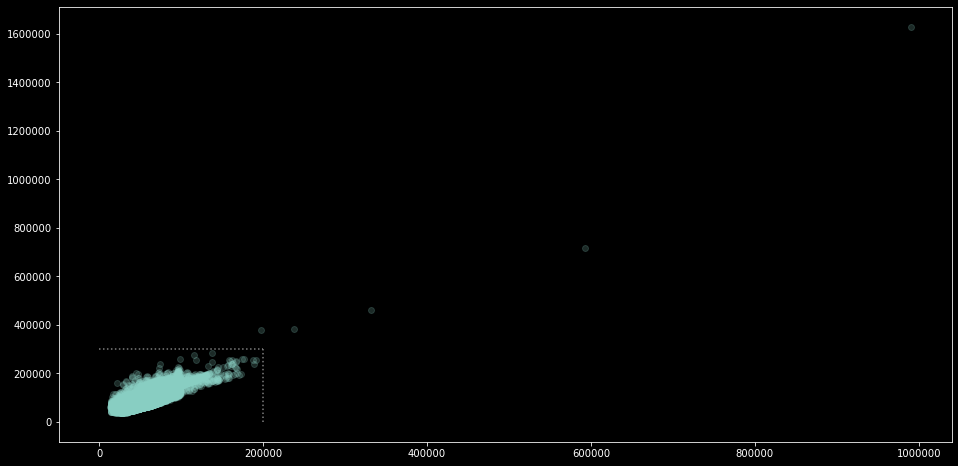

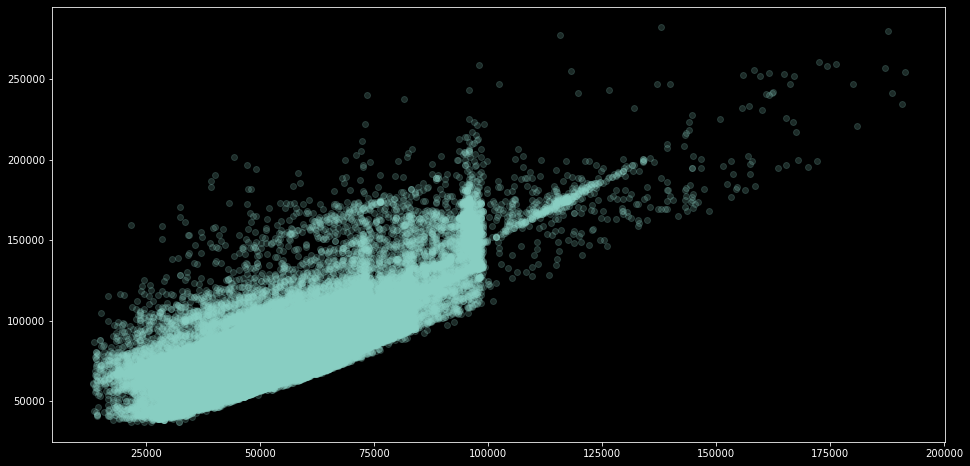

In [4]:
# ao observar o gráfico de dispersão entre as variáveis, percebemos a necessidade de eliminar outliers
# (ao menos para a visualização do gráfico de dispersão)

plt.scatter(df_treino['valor_emprestimo'], df_treino['custo_ativo'], alpha = 0.2)
plt.plot([0, 200000], [300000, 300000], color = 'grey', ls = ':')
plt.plot([200000, 200000], [0, 300000], color = 'grey', ls = ':')
plt.show()

aux = df.copy()
aux = aux.loc[(aux['valor_emprestimo'] <= 200000) & (aux['custo_ativo'] <= 300000)]
plt.scatter(aux['valor_emprestimo'], aux['custo_ativo'], alpha = 0.2)
plt.show()

In [50]:
print('r:', pearsonr(df['valor_emprestimo'], df['custo_ativo']))
print('r:', pearsonr(aux['valor_emprestimo'], aux['custo_ativo']))

# eliminar outliers nos ajudou a visualizar melhor a correlação, no gráfico de dispersão, mas continuo
# o projeto sem eliminá-los

r: (0.756227463624271, 0.0)
r: (0.7606224185256827, 0.0)


c:\users\fkhon\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


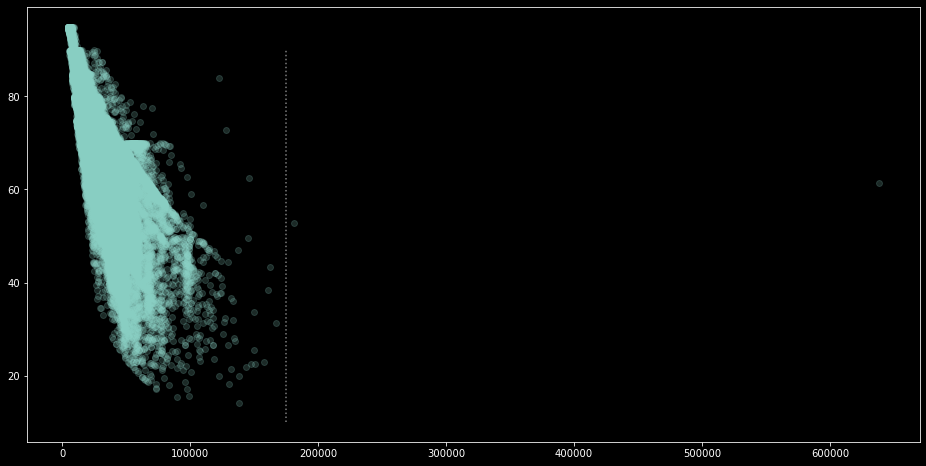

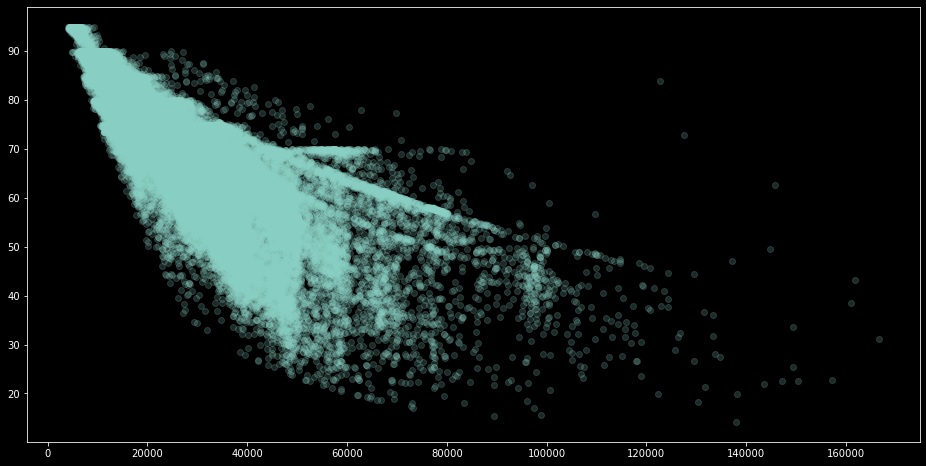

In [6]:
# combinando 'valor_emprestimo' e 'custo_ativo'
df_treino['dif_val_custo'] = df_treino['custo_ativo'] - df_treino['valor_emprestimo'] 

# agora nos restam as features 'dif_val_custo' e 'emprestimo_custo' 
plt.scatter(df_treino['dif_val_custo'], df_treino['emprestimo_custo'], alpha = 0.2)
plt.plot([175000, 175000], [10, 90], ls = ':', color = 'grey')
plt.show()

# novamente, outliers dificultam a visualização do plot
# estudo o cenário onde eliminamos os três pontos do lado direito da linha pontilhada cinza
aux = df_treino.copy()
aux = aux.loc[aux['dif_val_custo'] <= 175000]
plt.scatter(aux['dif_val_custo'], aux['emprestimo_custo'], alpha = 0.2)
plt.show()

In [49]:
print('r:', pearsonr(df_treino['dif_val_custo'], df_treino['emprestimo_custo']))
print('r:', pearsonr(aux['dif_val_custo'], aux['emprestimo_custo']))

# eliminar outliers nos ajudou a visualizar melhor a correlação, no gráfico de dispersão, mas continuo
# o projeto sem eliminá-los

# não sei como combinar estas duas features, posto que uma consiste em uma proporção, e outra em um valor
# 'inteiro', então, avaliarei a importância de uma contra a outra, discrertizando-as com árvores de decisão, 
# em seguida, plotando as taxas de 'default' para cada uma e julgando qual ordena o mesmo com maior eficácia

r: (-0.8430717082315322, 0.0)
r: (-0.8378076109522089, 0.0)


In [8]:
# para avaliar as variáveis quantitativas, utilizamos árvores de decisão, a fim de obter bins compreendendo
# 'ranges'; para visualizar como é a taxa de 'default' em cada bin, transformamos as series contendo a variável
# não discretizada, utilizando o 'predict_proba' da árvore, em seguida, plotamos um box plot entre a series
# que contém os valores retornados por 'predict_proba' e a variável original, a series contendo as 
# probabilidades é 'discretizada' para o plot, e para, posteriormente, rodar no modelo, mas acima de cada plot
# são exibidas, em ordem, as probabilidades de cada bin

# são testadas as possibilidades de 16, 8 e 4 bins

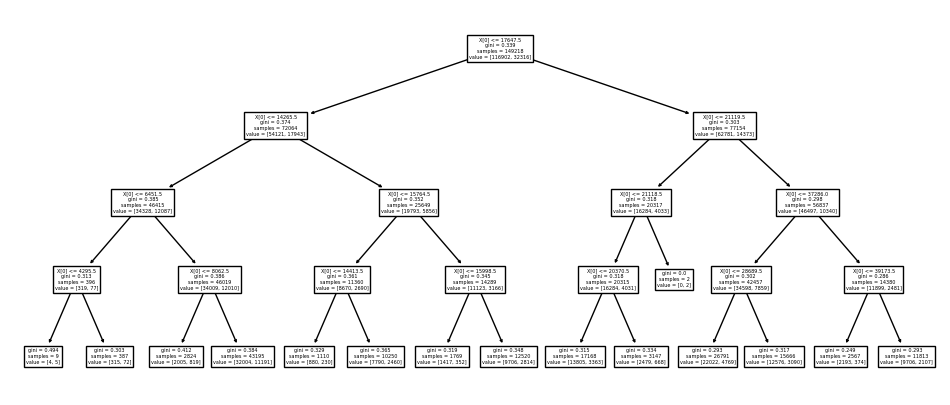

c:\users\fkhon\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\fkhon\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[0.1457, 0.17801, 0.17836, 0.18605, 0.19589, 0.19724, 0.19898, 0.20721, 0.21227, 0.22476, 0.24, 0.25908, 0.29001, 0.55556, 1.0]


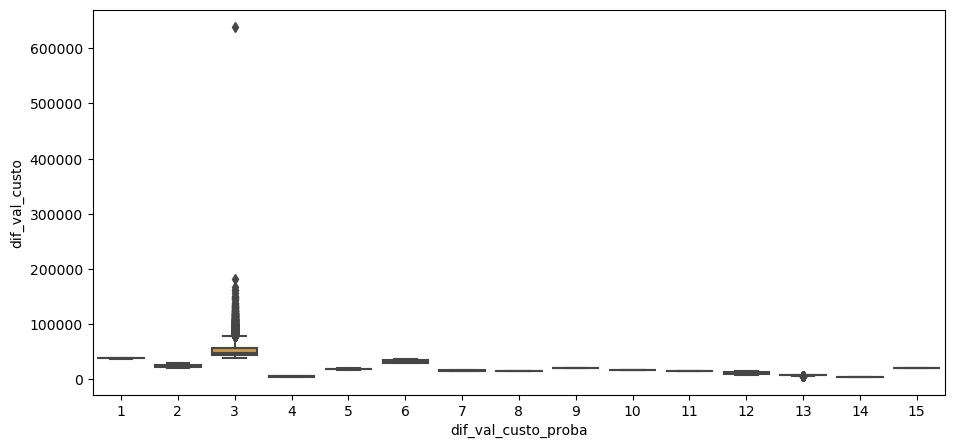

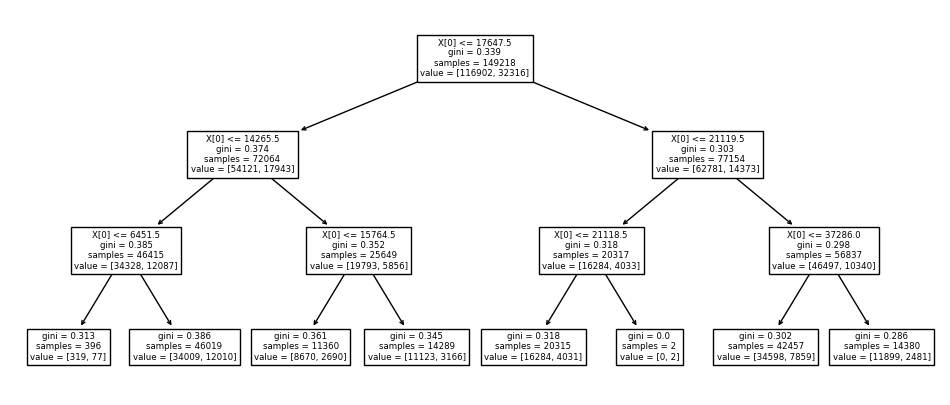

c:\users\fkhon\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\fkhon\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[0.17253, 0.1851, 0.19444, 0.19842, 0.22157, 0.2368, 0.26098, 1.0]


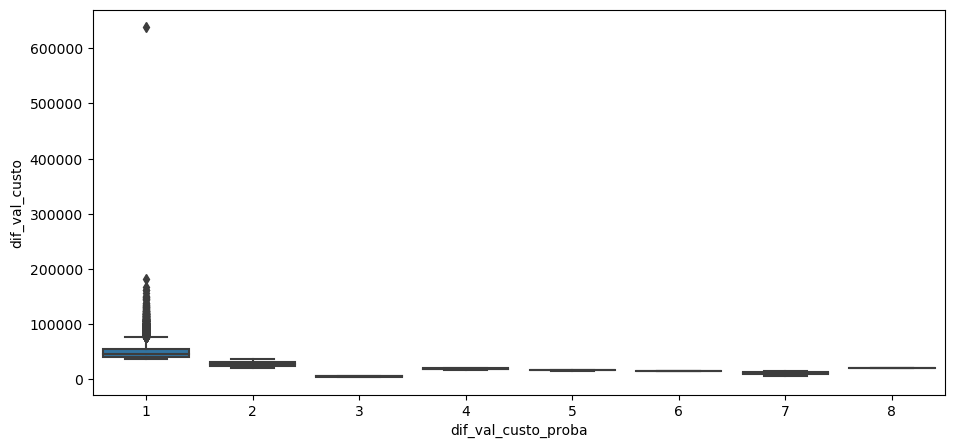

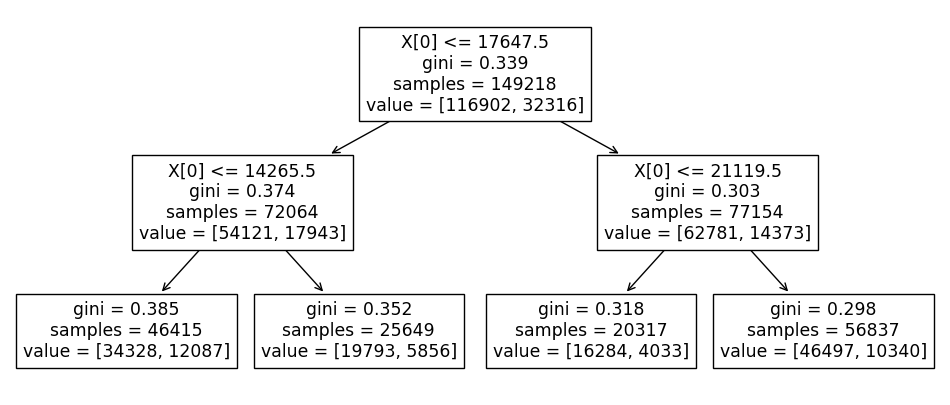

c:\users\fkhon\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\fkhon\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[0.18192, 0.1985, 0.22831, 0.26041]


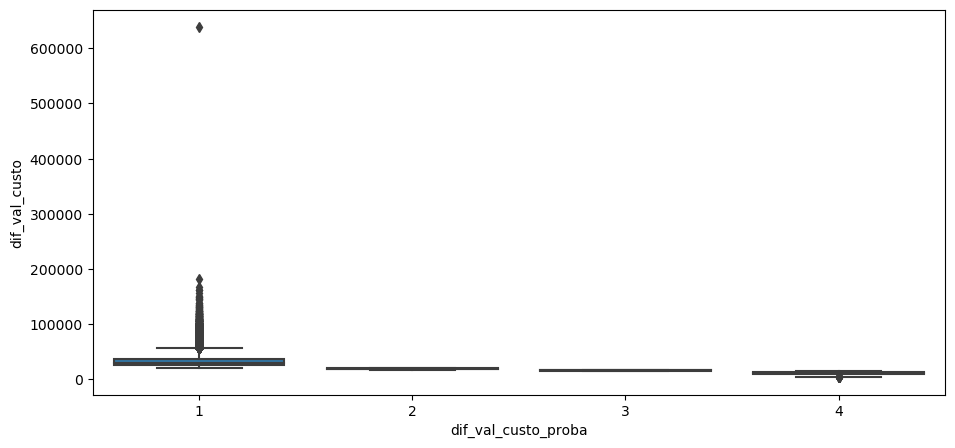

In [9]:
tree_box_plot(df_treino, 'dif_val_custo', 'default', [4, 3, 2], 42)

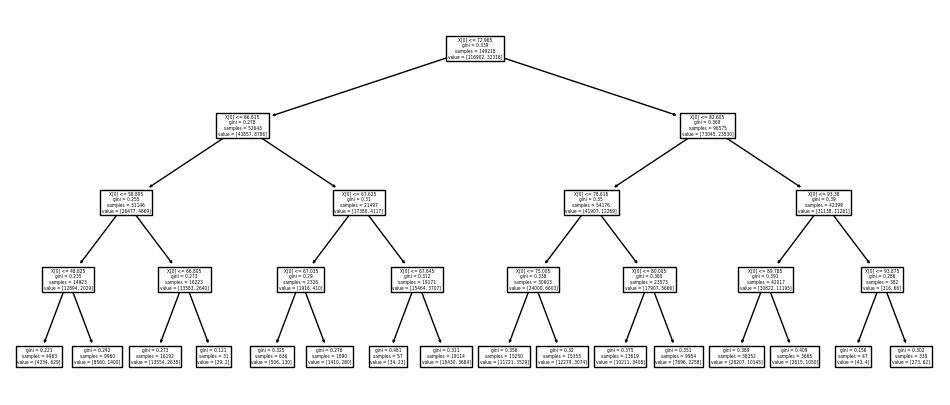

c:\users\fkhon\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\fkhon\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[0.06452, 0.08511, 0.12674, 0.14056, 0.16292, 0.16568, 0.18507, 0.19274, 0.20022, 0.2044, 0.22684, 0.23141, 0.25024, 0.26452, 0.28649, 0.40351]


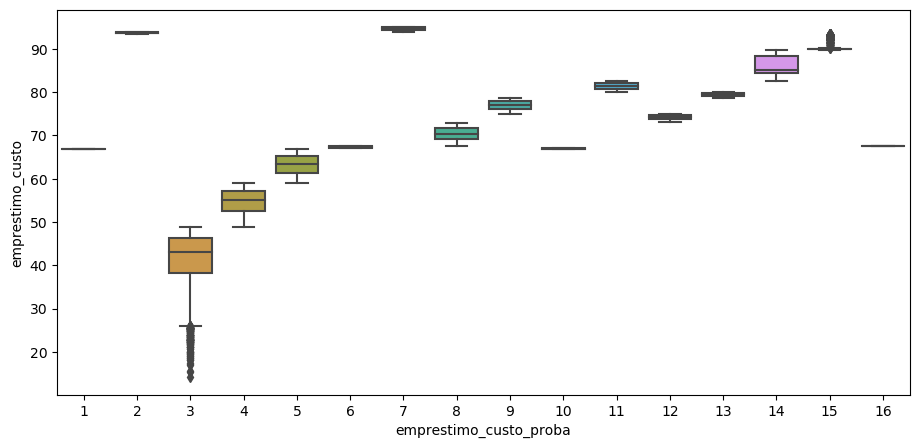

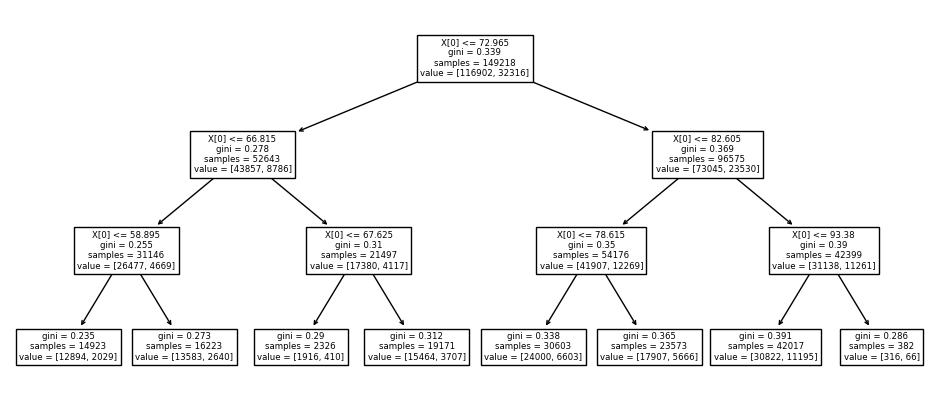

c:\users\fkhon\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\fkhon\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[0.13596, 0.16273, 0.17277, 0.17627, 0.19336, 0.21576, 0.24036, 0.26644]


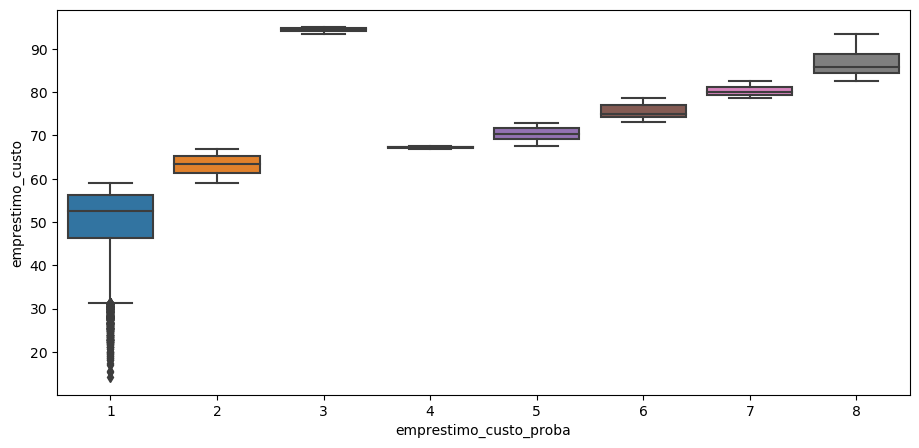

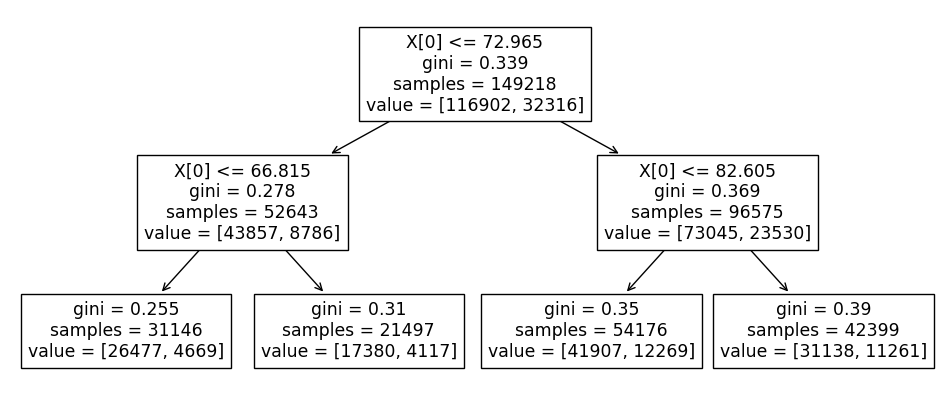

c:\users\fkhon\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\fkhon\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[0.14991, 0.19152, 0.22647, 0.2656]


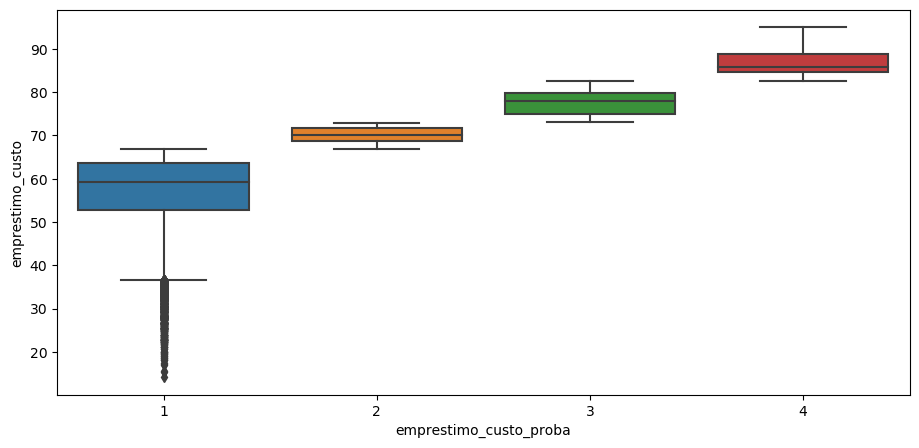

In [10]:
tree_box_plot(df_treino, 'emprestimo_custo', 'default', [4, 3, 2], 42)

In [11]:
# no caso de 'emprestimo_custo', percebe-se que existe uma correlação significativa com a probabilidade de 
# 'default'

# conclusão da análise de 'valor_emprestimo', 'custo_ativo', 'emprestimo_custo':
# talvez possamos usar a variável 'emprestimo_custo'

In [12]:
# em seguida, faço a análise e transformação de 'nascimento'

# possíveis anos de nascimento:
# suponho que todos sejam '19--', com exceção de '1900', neste caso, considero que o ano seja '2000'
df_treino['nascimento'].str[6:].unique()

array(['93', '87', '75', '91', '85', '83', '71', '94', '68', '70', '72',
       '84', '74', '90', '92', '88', '69', '81', '80', '95', '86', '89',
       '67', '82', '97', '96', '78', '77', '64', '58', '79', '73', '76',
       '98', '66', '61', '63', '62', '65', '99', '59', '56', '00', '60',
       '55', '57', '49', '54'], dtype=object)

c:\users\fkhon\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


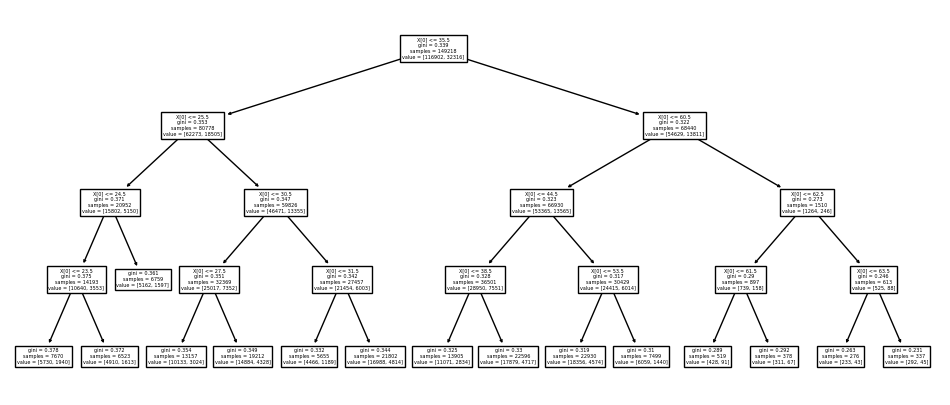

[0.13353, 0.1558, 0.17534, 0.17725, 0.19203, 0.19948, 0.20381, 0.20875, 0.21026, 0.22081, 0.22528, 0.22984, 0.23628, 0.24728, 0.25293]


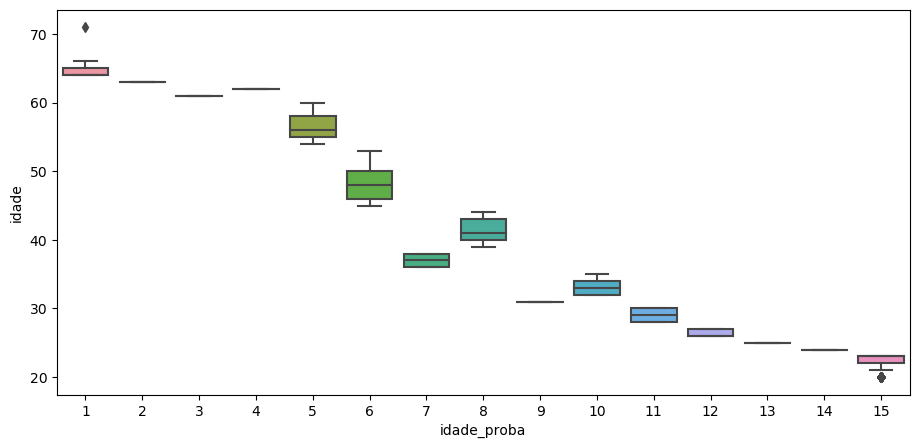

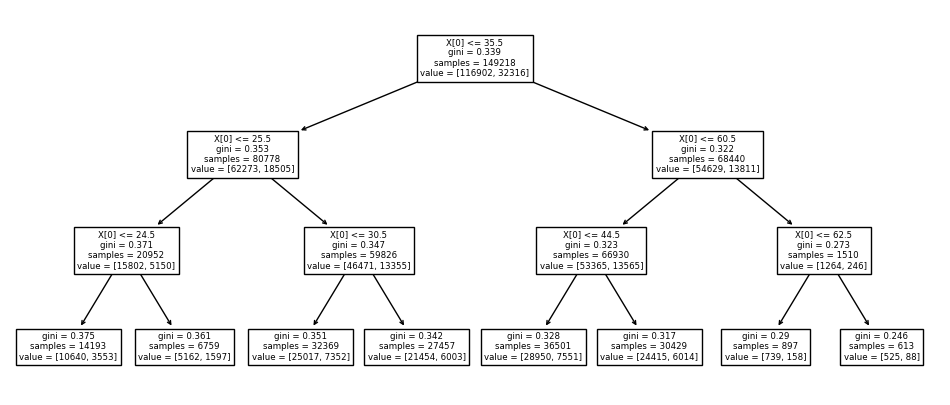

[0.14356, 0.17614, 0.19764, 0.20687, 0.21863, 0.22713, 0.23628, 0.25033]


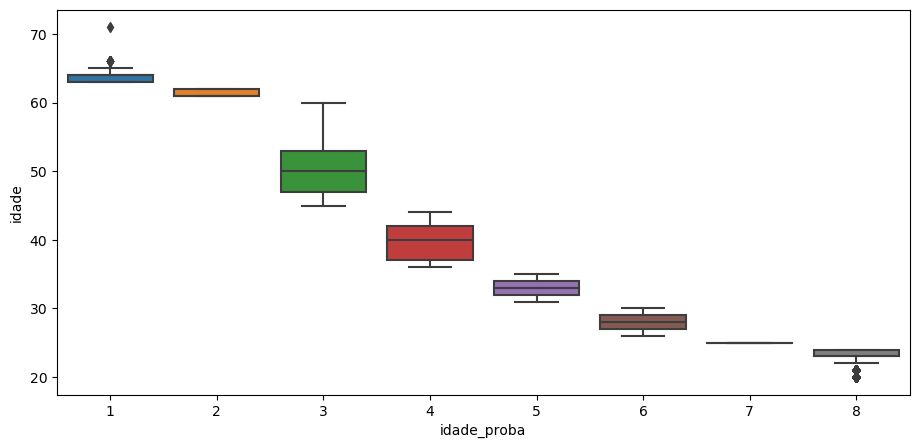

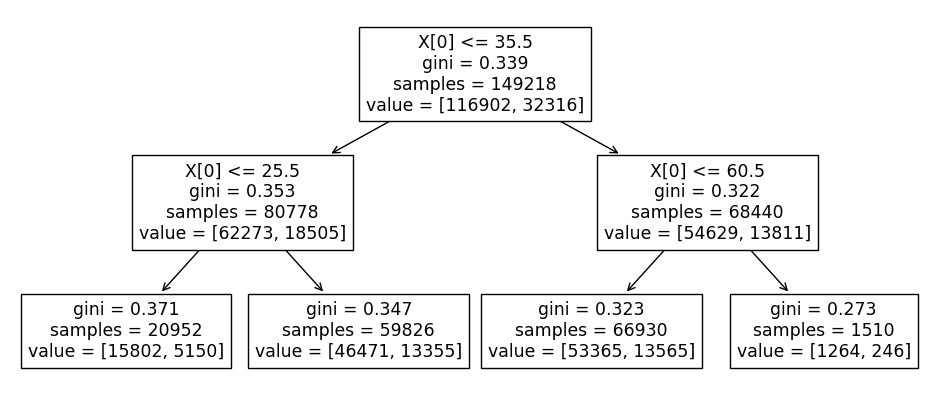

[0.16291, 0.20267, 0.22323, 0.2458]


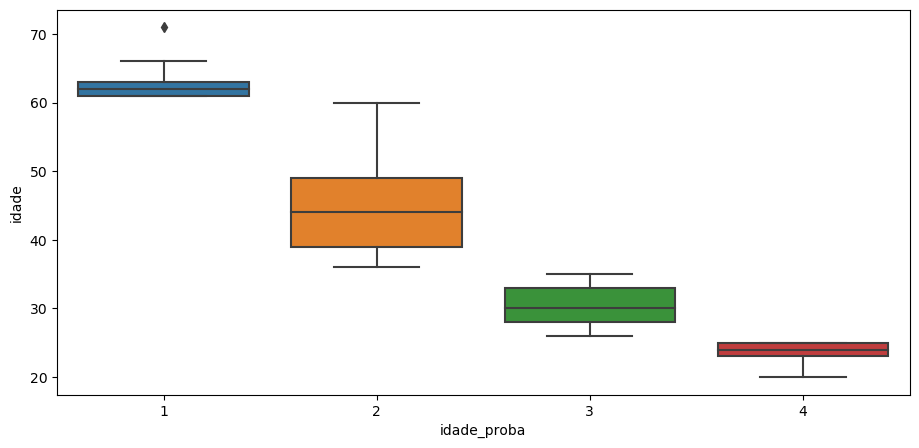

In [13]:
df_treino['nascimento'] = df_treino['nascimento'].str[6:].apply(lambda x: year_to_age(x))
df_treino = df_treino.rename(columns = {'nascimento': 'idade'})

tree_box_plot(df_treino, 'idade', 'default', [4, 3, 2], 42)

In [14]:
# conclusão da análise de idade:
# por mais que exista a possibilidade de gerar controvérsias, a variável idade ordena o 'default' de forma 
# consistente

In [15]:
# em seguida, faço a análise da variável emprego
print(df_treino['emprego'].isnull().value_counts())
df_treino['emprego'].unique()

# será necessário imputar alguns valores

False    144247
True       4971
Name: emprego, dtype: int64


array(['Self employed', 'Salaried', nan], dtype=object)

In [16]:
imp = SimpleImputer(strategy = 'constant', fill_value = 'Unknown')
df_treino['emprego'] = imp.fit_transform(df_treino[['emprego']])
df_treino['emprego'] = df_treino['emprego'].str.replace(' ', '_')

# como se trata de uma variável qualitativa não ordinal, repetirei o processo das variáveis anteriores
# em vez disso, opto por realizar teste qui-quadrado, caso este acuse dependência, é realizado cramer V, 
# mensurando a força da mesma

stat, crit, cramer = quali_var_indep_hyp_test(df_treino, 'emprego', 'default', 0.01)
print(round(stat, 2))
print(round(crit, 2))

# Com uma estatística qui-quadrada de 145.41, e um valor crítico de 9.21, falhamos em rejeitar a hipótese nula
# de independência, todavia, para quantificarmos a associação entre 'emprego' e 'default', consultamos
# Cramér's V, assim, sabemos se 'vale a pena' manter esta variável no modelo
round(cramer, 3)

101.05
9.21


0.026

In [17]:
# conclusão da análise de emprego:
# associação insignificante

In [18]:
# em seguida, análise de 'score' e 'score_desc'

# suponho que seria seguro supor que estas variáveis trazem informações redundantes, entretanto, segue a
# análise destas, a fim de garantir que não perderemos informação, ao eliminar uma delas

df_treino['score_desc'].value_counts(1)

No Bureau History Available                                0.502721
C-Very Low Risk                                            0.068511
A-Very Low Risk                                            0.060696
D-Very Low Risk                                            0.048406
B-Very Low Risk                                            0.039204
M-Very High Risk                                           0.037931
F-Low Risk                                                 0.036484
K-High Risk                                                0.035069
H-Medium Risk                                              0.029279
E-Low Risk                                                 0.024776
I-Medium Risk                                              0.023489
G-Low Risk                                                 0.017357
J-High Risk                                                0.016298
Not Scored: Sufficient History Not Available               0.016245
Not Scored: Not Enough Info available on the cus

In [19]:
# em um primeiro momento, de forma grosseira, considero a possibilidade de dividir os possíveis valores de 
# 'score_desc' entre possuindo a palavra 'Risk' ou se iniciar com 'No'

print(df_treino.loc[df_treino['score_desc'].str.contains('No'), 'score_desc'].unique().tolist())
print('')
print(df_treino.loc[(df_treino['score_desc'].str.contains('Risk')) | 
                    (df_treino['score_desc'].str.contains('Risk')), 'score_desc'].unique().tolist())

['No Bureau History Available', 'Not Scored: Sufficient History Not Available', 'Not Scored: No Updates available in last 36 months', 'Not Scored: Not Enough Info available on the customer', 'Not Scored: No Activity seen on the customer (Inactive)', 'Not Scored: Only a Guarantor', 'Not Scored: More than 50 active Accounts found']

['G-Low Risk', 'A-Very Low Risk', 'B-Very Low Risk', 'C-Very Low Risk', 'F-Low Risk', 'M-Very High Risk', 'D-Very Low Risk', 'L-Very High Risk', 'K-High Risk', 'H-Medium Risk', 'E-Low Risk', 'J-High Risk', 'I-Medium Risk']


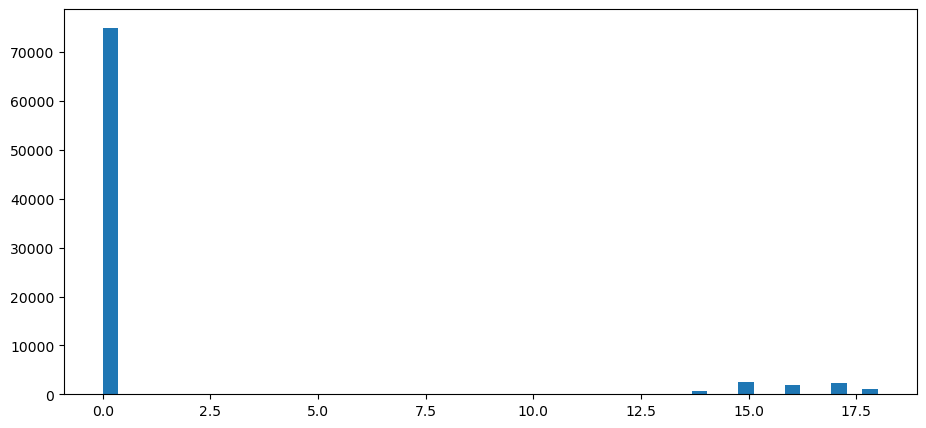

In [20]:
# a partir deste ponto, considero dois tipos de 'score_desc', os que contém 'Risk' e os que contém 'No'

# como se comporta o 'score', em dados que possuem 'No' em 'score_desc' ?
# como é o score de dados nestes grupos ?
no_score = df_treino.loc[df_treino['score_desc'].str.contains('No'), 'score_desc'].unique().tolist()
no_score_score_series = df_treino.loc[df['score_desc'].isin(no_score), 'score']
plt.hist(no_score_score_series, bins = 50)
plt.show()

In [21]:
# dados que possuem 'No' em seus 'score_desc' consistem principalmente em zeros, não chegando a 18, 
# a princípio, não farei a discretização dos dados decidindo os limiares por conta própria, mas consigo 
# imaginar que poderíamos alocar todos os dados contendo 'No' em 'score_desc' sob a mesma categoria

# aprofundando análise dos valores de 'score_desc' que possuem 'Risk' ou 'risk'

print(df_treino.loc[df_treino['score_desc'].str.contains('Very Low'), 'score_desc'].unique())
print(df_treino.loc[(df_treino['score_desc'].str.contains('Low')) &
     (df_treino['score_desc'].str.contains('Very') == False), 'score_desc'].unique())
print(df_treino.loc[df_treino['score_desc'].str.contains('Medium'), 'score_desc'].unique())
print(df_treino.loc[(df_treino['score_desc'].str.contains('High')) &
             (df_treino['score_desc'].str.contains('Very') == False), 'score_desc'].unique())
print(df_treino.loc[df_treino['score_desc'].str.contains('Very High'), 'score_desc'].unique())

['A-Very Low Risk' 'B-Very Low Risk' 'C-Very Low Risk' 'D-Very Low Risk']
['G-Low Risk' 'F-Low Risk' 'E-Low Risk']
['H-Medium Risk' 'I-Medium Risk']
['K-High Risk' 'J-High Risk']
['M-Very High Risk' 'L-Very High Risk']


In [22]:
# o que querem dizer as letras?
# r:são subgrupos de cada tipo de risco, o risco aumenta conforme se percorre o alfabeto

# Very Low Risk (A, B, C, D)
# Low Risk (E, F, G)
# Medium Risk (H, I)
# High Risk (J, K)
# Very High Risk (L, M)

# como se comporta o 'score', para cada 'score_desc'
# dividir dados pela letra presente no 'score_desc'

df_risk_letter = df_treino.copy()
df_risk_letter = df_risk_letter.loc[(df_risk_letter['score_desc'].str.contains('Risk')) |
                                    (df_risk_letter['score_desc'].str.contains('risk'))]
df_risk_letter['risk_letter'] = df_risk_letter['score_desc'].str[0]
df_risk_letter[['risk_letter', 'score']].groupby('risk_letter').mean()

,score
risk_letter,
A,827.704980
B,774.056239
C,741.915974
D,715.950436
E,691.485799
F,666.182403
G,640.929344
H,617.237125
I,586.766049


In [23]:
# dividir dados pelo valor presente no 'score_desc', desconsiderando a letra

df_risk_word = df_treino.copy()
df_risk_word = df_risk_word.loc[(df_risk_word['score_desc'].str.contains('Risk')) |
                 (df_risk_word['score_desc'].str.contains('risk'))]
df_risk_word['risk_word'] = df_risk_word['score_desc'].str[2:]
df_risk_word[['risk_word', 'score']].groupby('risk_word').mean().sort_values('score')

,score
risk_word,
Very High Risk,302.905061
High Risk,474.834051
Medium Risk,603.673355
Low Risk,668.581280
Very Low Risk,765.946589


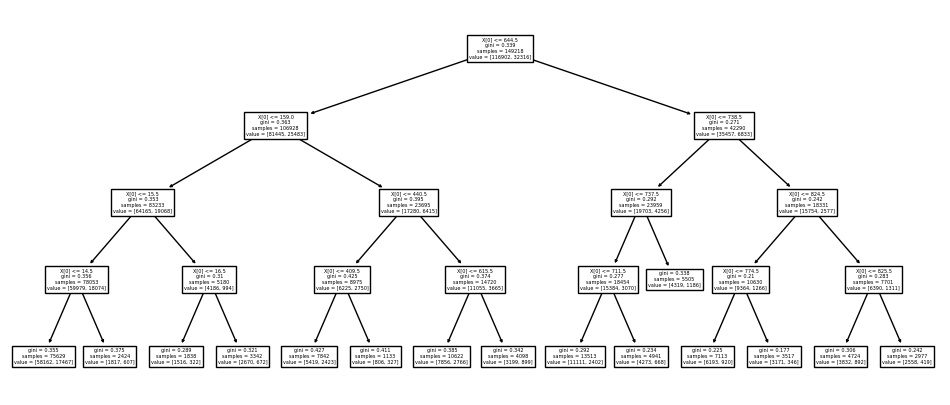

[0.09838, 0.12934, 0.1352, 0.14075, 0.17519, 0.17775, 0.18882, 0.20108, 0.21544, 0.21938, 0.23096, 0.25041, 0.2604, 0.28861, 0.30898]


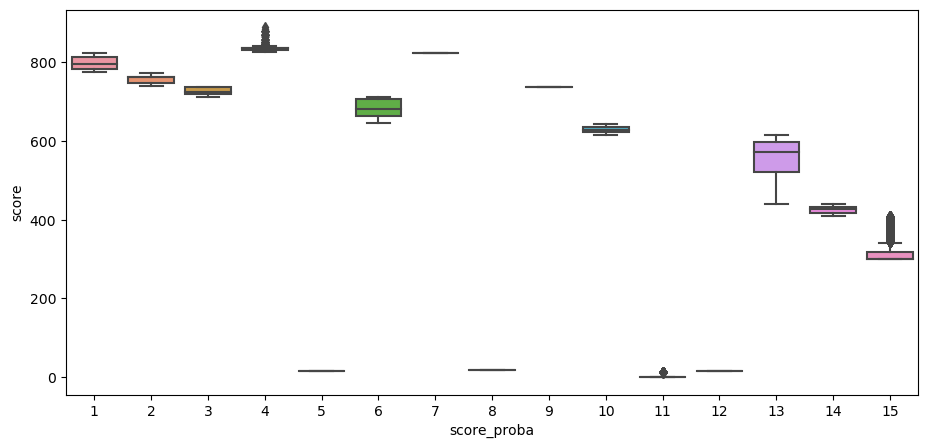

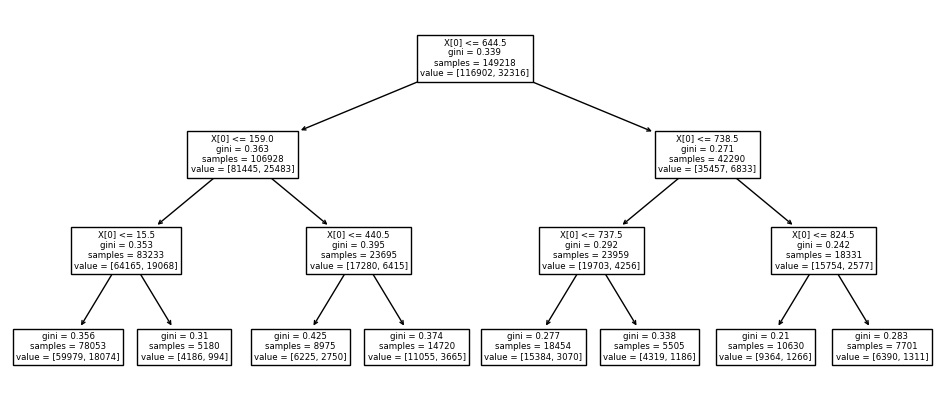

[0.1191, 0.16636, 0.17024, 0.19189, 0.21544, 0.23156, 0.24898, 0.30641]


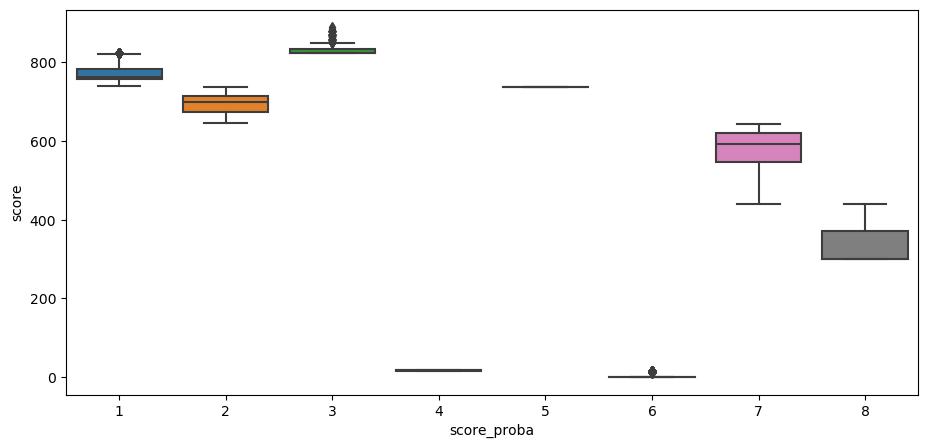

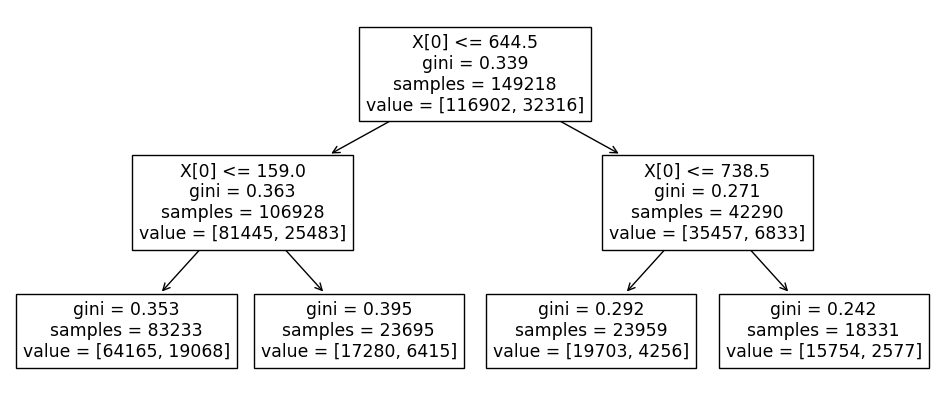

[0.14058, 0.17764, 0.22909, 0.27073]


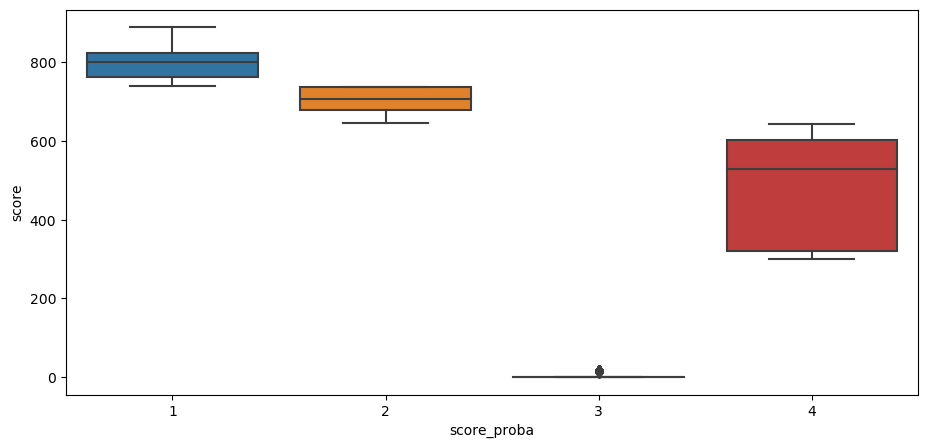

In [24]:
# com estas informações, concluo que não há necessidade de manter ambas variáveis('score' e 'score_desc')
# opto por manter 'score'

# prosseguindo com a análise de 'score'
tree_box_plot(df_treino, 'score', 'default', [4, 3, 2], 42)

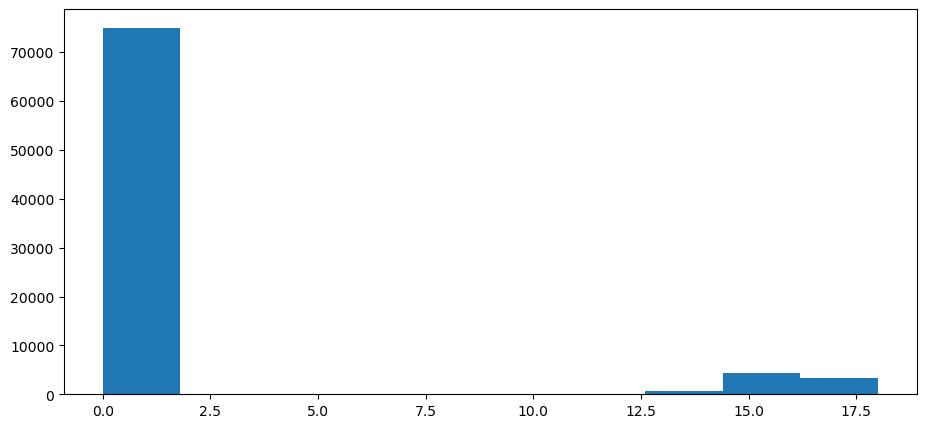

In [25]:
# resultado curioso, a expectativa era de que esta variável trouxesse muita informação sobre o alvo
# o que aconteceu em 3?
plt.hist(df_treino.loc[df_treino['score_proba'] == 3, 'score'])
plt.show()

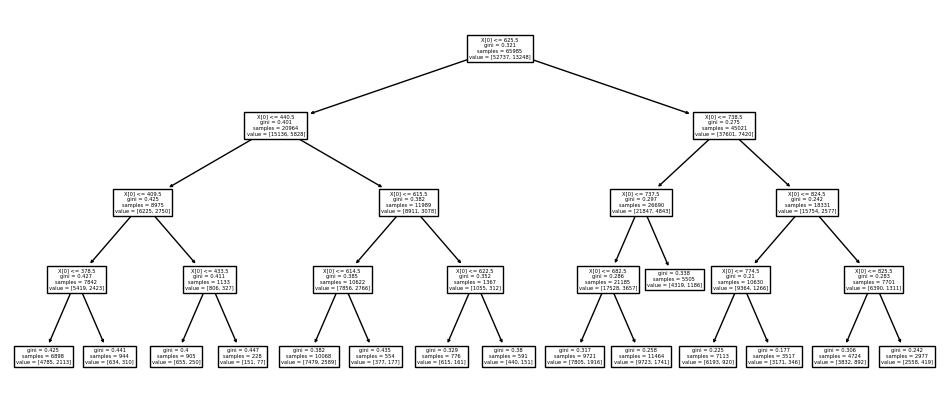

[0.09838, 0.12934, 0.14075, 0.15187, 0.18882, 0.1971, 0.20747, 0.21544, 0.2555, 0.25715, 0.27624, 0.30632, 0.31949, 0.32839, 0.33772]


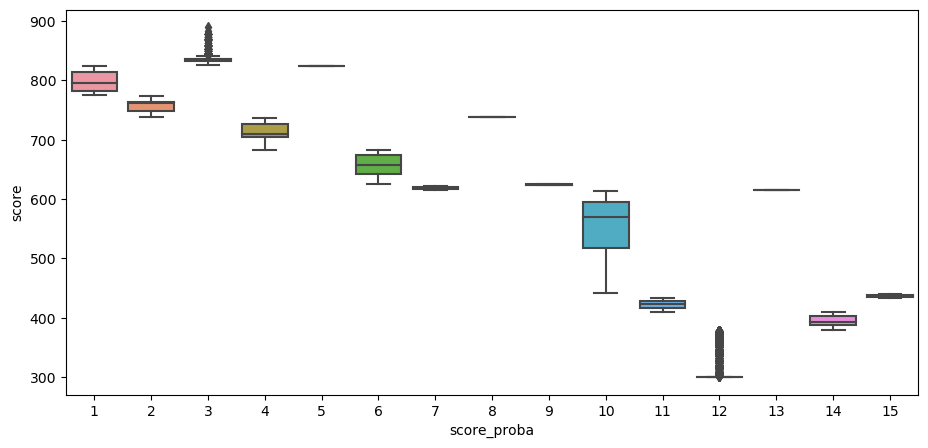

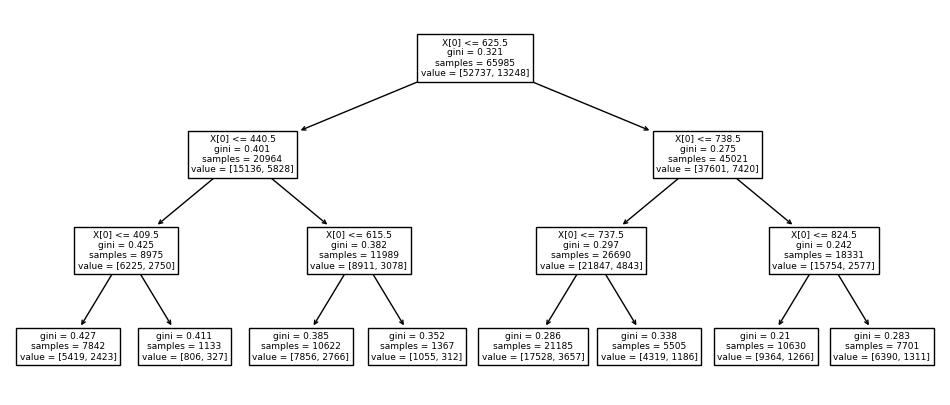

[0.1191, 0.17024, 0.17262, 0.21544, 0.22824, 0.2604, 0.28861, 0.30898]


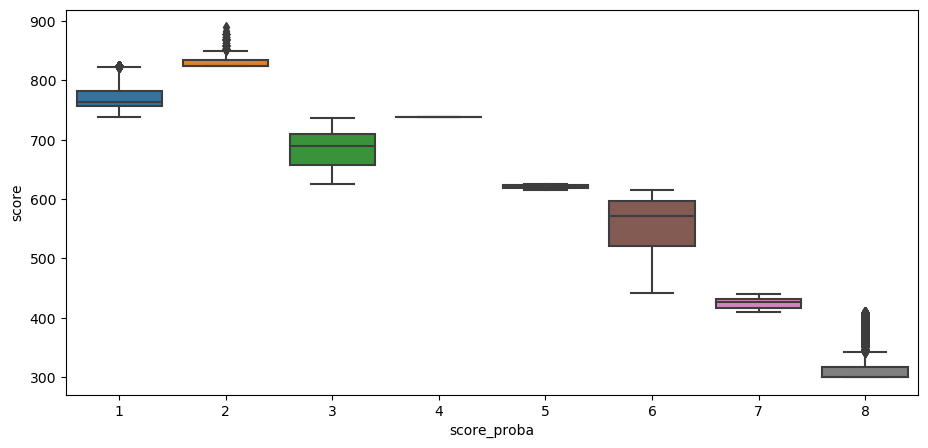

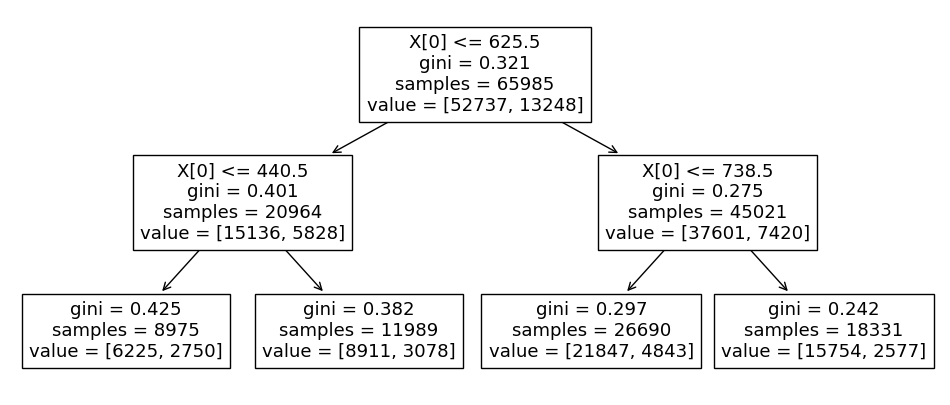

[0.14058, 0.18145, 0.25674, 0.30641]


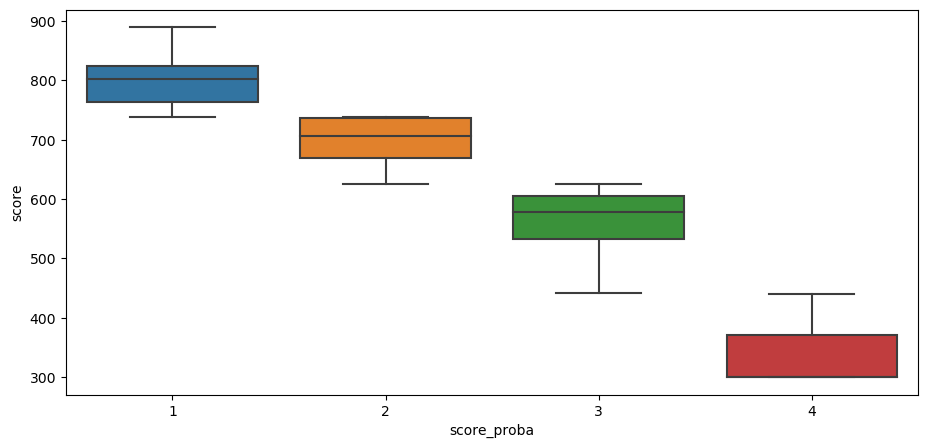

In [26]:
# o grande número de scores iguais a 0 tornam a variável 'score' menos confiável, 
# para contornar este problema, podemos alocar este grupo de dados sob a categoria 0, antes de passar os
# dados no modelo

# como ficariam os dados de 'score', sem o grande volume de zeros ?
aux = df_treino.copy()
aux = aux.loc[df['score'] > 20]
tree_box_plot(aux, 'score', 'default', [4, 3, 2], 42)

In [27]:
# notamos que com 8 ou mais bins, a variável continua inconsistente, mas com 4, ela passa a ser útil,
# após lidarmos com os zeros

# conclusão da análie de 'score' e 'score_desc': podemos utilizar 'score', alocando valores de 0-18 sob a 
# categoria 0 e posteriormente, criando 4 bins para os valores restantes

In [28]:
# em seguida, análise de 'tem_med_emp' e 'tem_pri_emp'

# em que formato se encontram os dados ?

print(df_treino['tem_med_emp'].unique()[0:5])
print(df_treino['tem_pri_emp'].unique()[0:5])
# percebe-se que todos possuem inteiros, seguidos de 'yrs' e 'mon', (anos, meses)
# pretendo transformar os valores em meses apenas (1 ano = 12 meses)
df_treino['tem_med_emp'] = df_treino['tem_med_emp'].apply(lambda x: time_unit_unification(x))
df_treino['tem_pri_emp'] = df_treino['tem_pri_emp'].apply(lambda x: time_unit_unification(x))

['0yrs 0mon' '1yrs 3mon' '0yrs 6mon' '0yrs 7mon' '1yrs 11mon']
['0yrs 0mon' '2yrs 3mon' '0yrs 6mon' '0yrs 7mon' '7yrs 2mon']


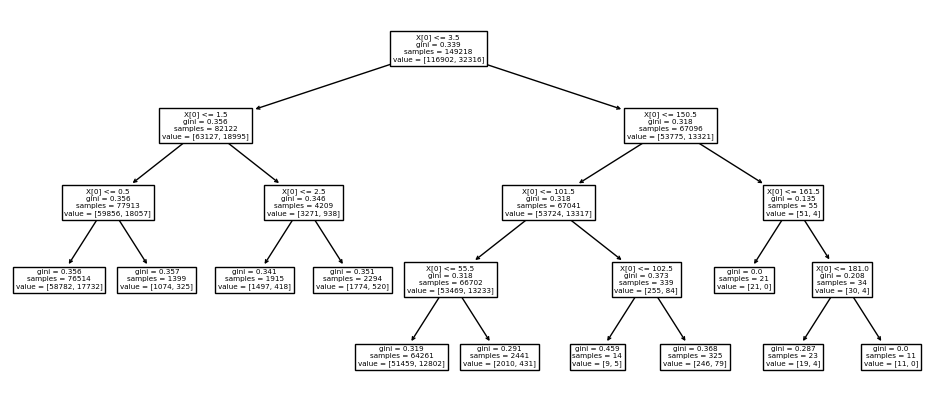

[0.0, 0.17391, 0.17657, 0.19922, 0.21828, 0.22668, 0.23175, 0.23231, 0.24308, 0.35714]


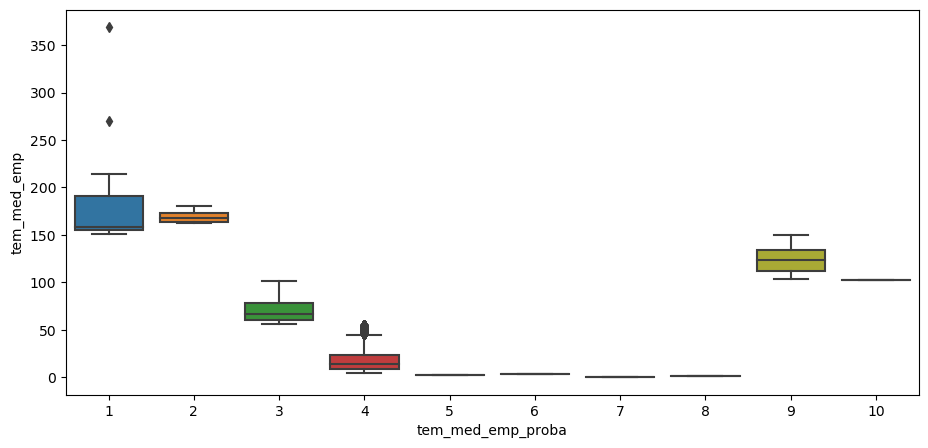

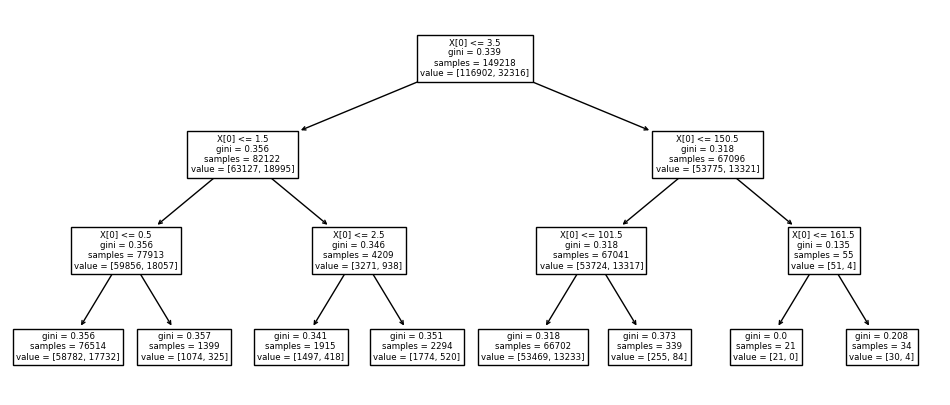

[0.0, 0.11765, 0.19839, 0.21828, 0.22668, 0.23175, 0.23231, 0.24779]


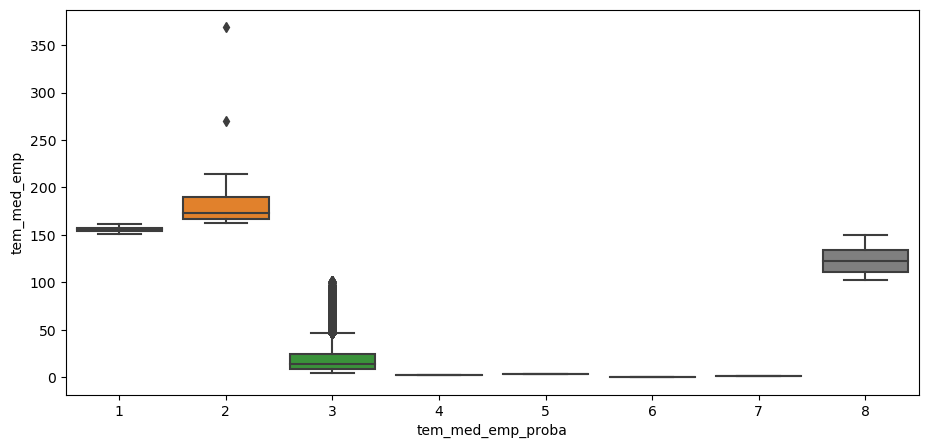

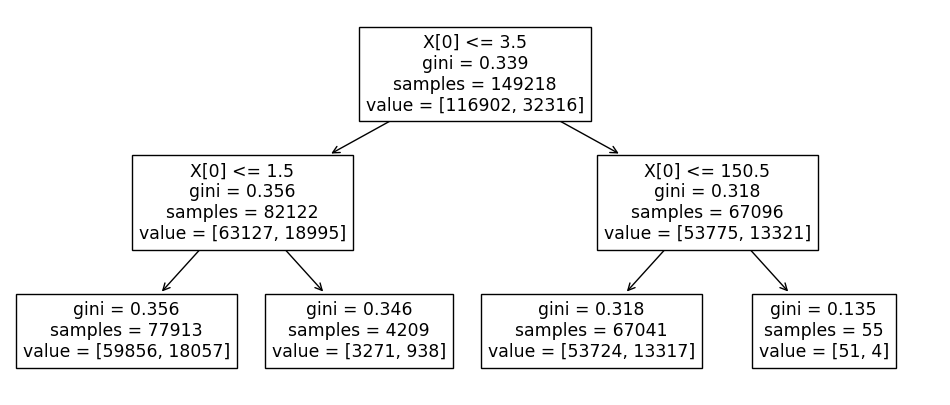

[0.07273, 0.19864, 0.22286, 0.23176]


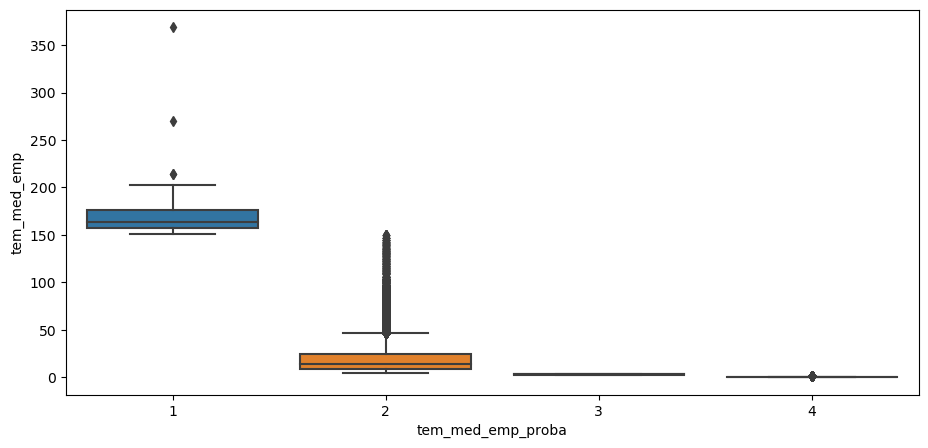

In [29]:
tree_box_plot(df_treino, 'tem_med_emp', 'default', [4, 3, 2], 42)

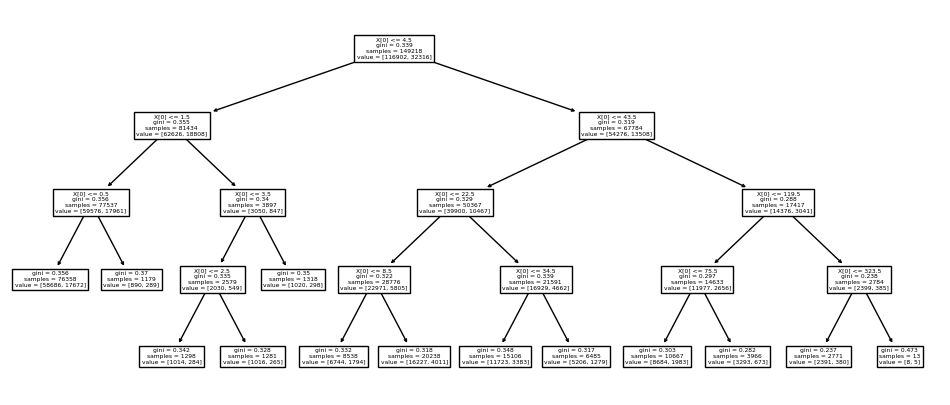

[0.13713, 0.16969, 0.1859, 0.19722, 0.19819, 0.20687, 0.21012, 0.2188, 0.22395, 0.2261, 0.23144, 0.24512, 0.38462]


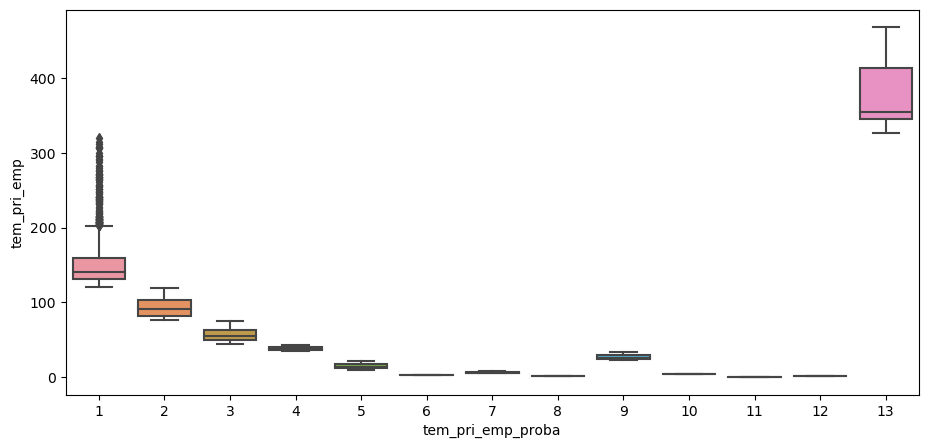

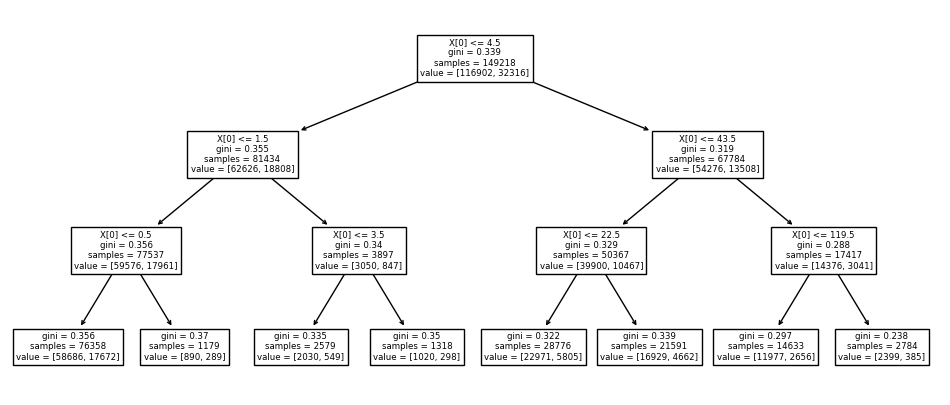

[0.13829, 0.18151, 0.20173, 0.21287, 0.21592, 0.2261, 0.23144, 0.24512]


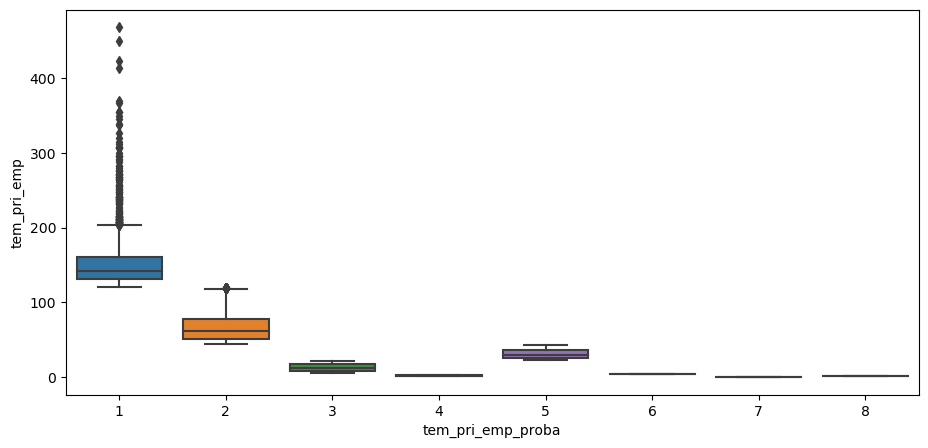

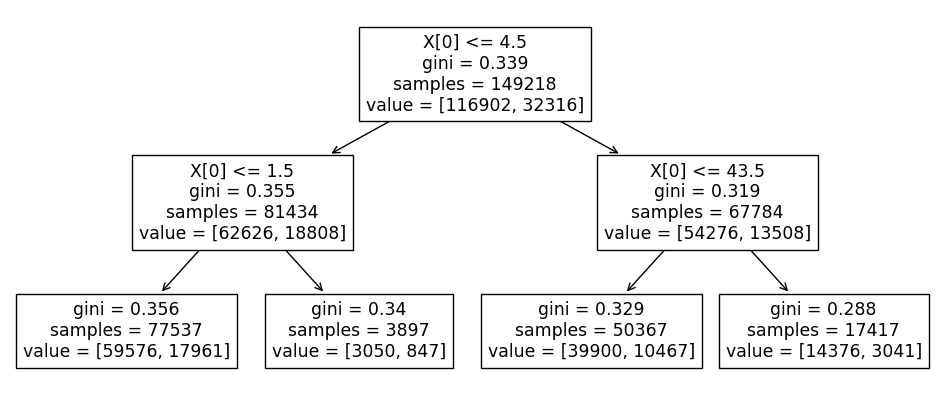

[0.1746, 0.20781, 0.21735, 0.23164]


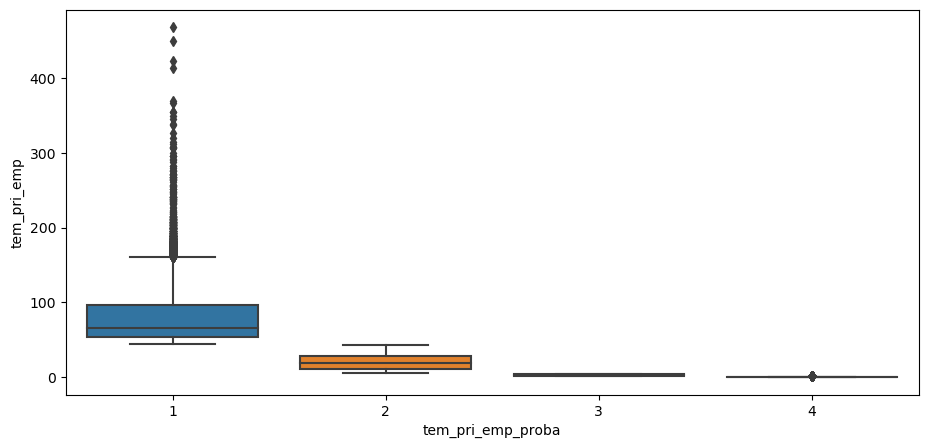

In [30]:
tree_box_plot(df_treino, 'tem_pri_emp', 'default', [4, 3, 2], 42)

In [31]:
# conclusão da análise de  'tem_med_emp' e 'tem_pri_emp':
# se formos comparar os plots das variáveis, percebe-se uma tendência mais definida em 'tem_pri_emp'

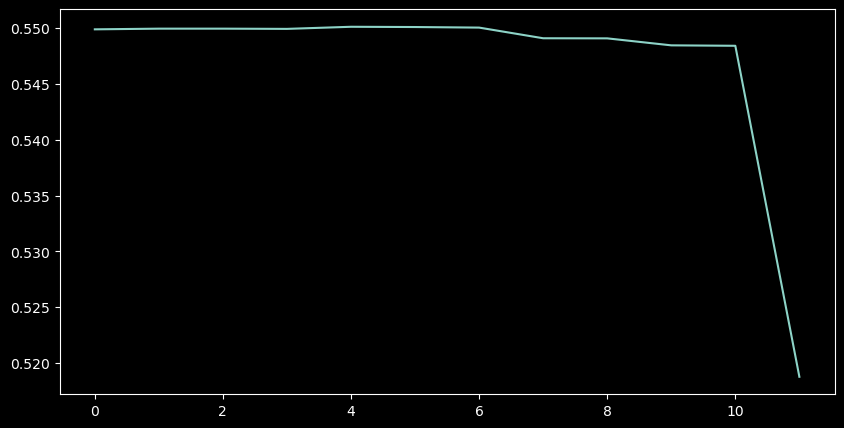

FEATURES INCLUÍDAS EM CADA STEP
0 : ['pri_qtd_tot_emp', 'pri_qtd_tot_emp_atv', 'pri_qtd_tot_def', 'pri_emp_abt', 'pri_emp_san', 'pri_emp_tom', 'sec_qtd_tot_emp', 'sec_qtd_tot_emp_atv', 'sec_qtd_tot_def', 'sec_emp_abt', 'sec_emp_san', 'sec_emp_tom']
1 : ['pri_qtd_tot_emp', 'pri_qtd_tot_emp_atv', 'pri_qtd_tot_def', 'pri_emp_abt', 'pri_emp_san', 'pri_emp_tom', 'sec_qtd_tot_emp', 'sec_qtd_tot_def', 'sec_emp_abt', 'sec_emp_san', 'sec_emp_tom']
2 : ['pri_qtd_tot_emp', 'pri_qtd_tot_emp_atv', 'pri_qtd_tot_def', 'pri_emp_abt', 'pri_emp_san', 'pri_emp_tom', 'sec_qtd_tot_emp', 'sec_qtd_tot_def', 'sec_emp_abt', 'sec_emp_tom']
3 : ['pri_qtd_tot_emp', 'pri_qtd_tot_emp_atv', 'pri_qtd_tot_def', 'pri_emp_abt', 'pri_emp_san', 'pri_emp_tom', 'sec_qtd_tot_emp', 'sec_qtd_tot_def', 'sec_emp_abt']
4 : ['pri_qtd_tot_emp', 'pri_qtd_tot_emp_atv', 'pri_qtd_tot_def', 'pri_emp_san', 'pri_emp_tom', 'sec_qtd_tot_emp', 'sec_qtd_tot_def', 'sec_emp_abt']
5 : ['pri_qtd_tot_emp', 'pri_qtd_tot_def', 'pri_emp_san', 'pri_em

In [32]:
# em seguida, análise das variáveis referentes às contas primária e secundária: 'pri_qtd_tot_emp', 
# 'pri_qtd_tot_emp_atv', 'pri_qtd_tot_def', 'pri_emp_abt', 'pri_emp_san', 'pri_emp_tom', 'sec_qtd_tot_emp',
# 'sec_qtd_tot_emp_atv', 'sec_qtd_tot_def', 'sec_emp_abt', 'sec_emp_san','sec_emp_tom'

# para lidar como estas, é feito algo similar à 'backwards stepwise logistic regression'; dado determinado
# conjunto inicial de variáveis explicativas (normalizadas), treinamos uma regressão logística e obtemos a 
# métrica de interesse (ROC AUC), em seguida, por meio da análise dos coeficientes de cada variável, 
# identificamos e eliminamos a variável 'menos importante' e obtemos a métrica de interesse novamente; este
# processo se repete até que haja apenas uma variável explicativa restante; as informações de cada etapa do
# processo são exibidas abaixo

accs = df_treino[['pri_qtd_tot_emp', 'pri_qtd_tot_emp_atv', 'pri_qtd_tot_def',
       'pri_emp_abt', 'pri_emp_san', 'pri_emp_tom', 'sec_qtd_tot_emp',
       'sec_qtd_tot_emp_atv', 'sec_qtd_tot_def', 'sec_emp_abt', 'sec_emp_san',
       'sec_emp_tom', 'default']]

plot_stepwise(accs, 'default')

In [33]:
# conclusão da análise das variáveis referentes às contas:
# a partir do step '10', percebe-se queda brusca na métrica;
# 10 : ['pri_qtd_tot_emp', 'pri_qtd_tot_def']
# conjunto de variáveis pode ser interessante

In [34]:
# neste ponto do notebook, todas as features que nos propusemos a analisar foram analisadas

# as features que se mostraram mais interessantes foram 'emprestimo_custo_proba' , 'idade_proba',
# 'score_proba' ,'tem_pri_emp_proba', em 4 bins (score precisa ser tratada à parte)
# * incluir as variáveis do step 7 *

df_x = df_treino.copy()
df_x = df_x[['emprestimo_custo_proba', 'idade_proba', 'tem_pri_emp_proba', 'score', 
             'pri_qtd_tot_emp', 'pri_qtd_tot_def', 'default']]

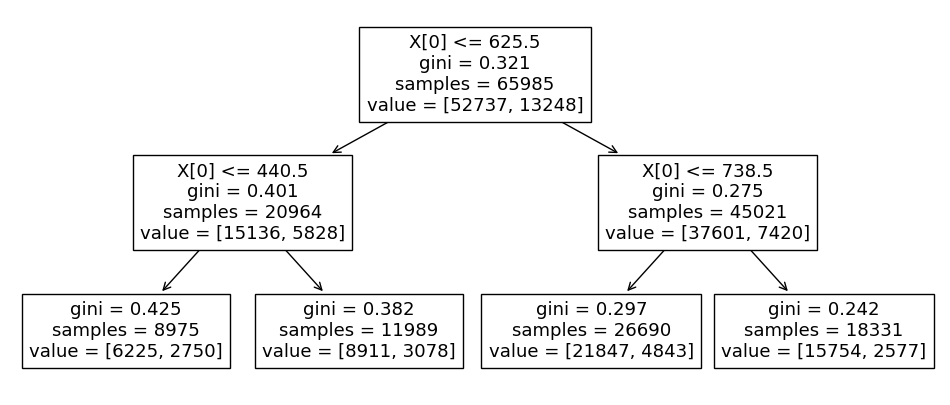

In [35]:
# tratando 'score' (criando bin exclusivo para valores de 0-18), anteriormente, concluímos que seria necessário
# tratar 'score' à parte, mas não o fizemos, este é o tratamento realmente sendo feito

plt.style.use('default')
df_x.loc[df_x.index.isin(df_x.loc[df_x['score'] < 20].index), 'score'] = 0
x = df_x.loc[df_x['score'] != 0][['score']]
y = df_x.loc[df_x['score'] != 0][['default']]
mdl = DecisionTreeClassifier(random_state = 42, max_depth = 2)
mdl.fit(x, y)
fig = plt.figure(figsize = (12, 5))
_ = tree.plot_tree(mdl)
plt.show()

In [36]:
def score_new_disc(x, t1, t2, t3):
    if x <= t1:
        return 1
    elif x > t1 and x <= t2:
        return 2
    elif x > t2 and x <= t3:
        return 3
    elif x > t3:
        return 4
    
z_series = df_x.loc[df_x['score'] == 0]['score']
nonz_series = df_x.loc[df_x['score'] != 0]['score'].apply(lambda x: score_new_disc(x, 440.5, 625.5, 738.5))

disctzd_score = pd.concat([z_series, nonz_series])
disctzd_score = disctzd_score.rename('new_score')
df_x = df_x.join(disctzd_score).drop(columns = ['score'])

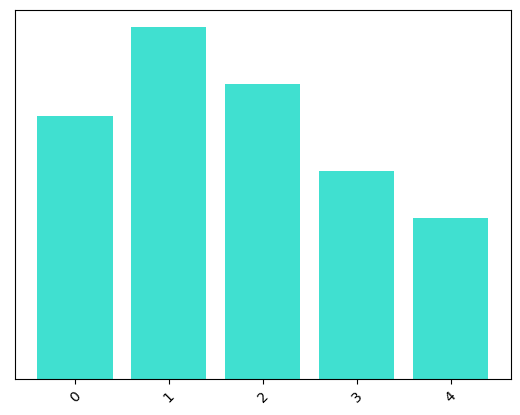

In [37]:
target_prop_bin(df_x, 'new_score', 'default')

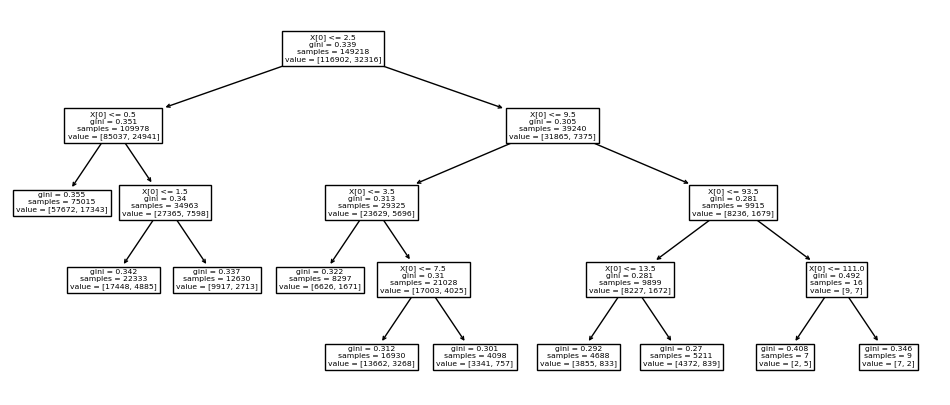

[0.16101, 0.17769, 0.18472, 0.19303, 0.2014, 0.21481, 0.21873, 0.22222, 0.23119, 0.71429]


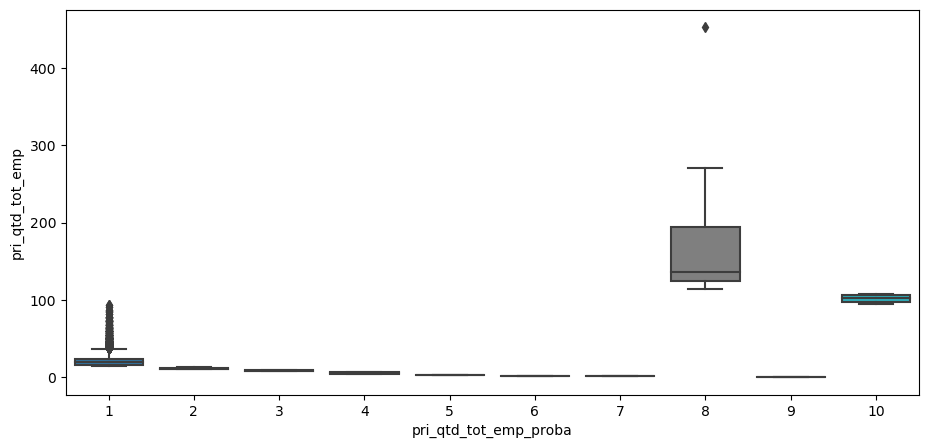

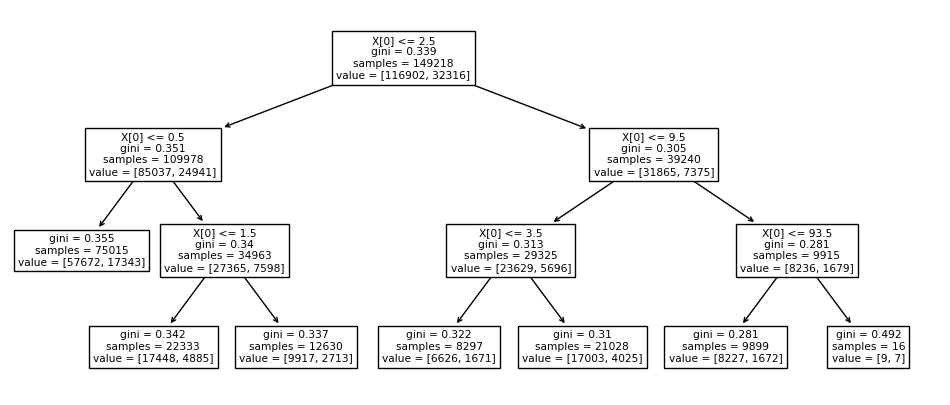

[0.16891, 0.19141, 0.2014, 0.21481, 0.21873, 0.23119, 0.4375]


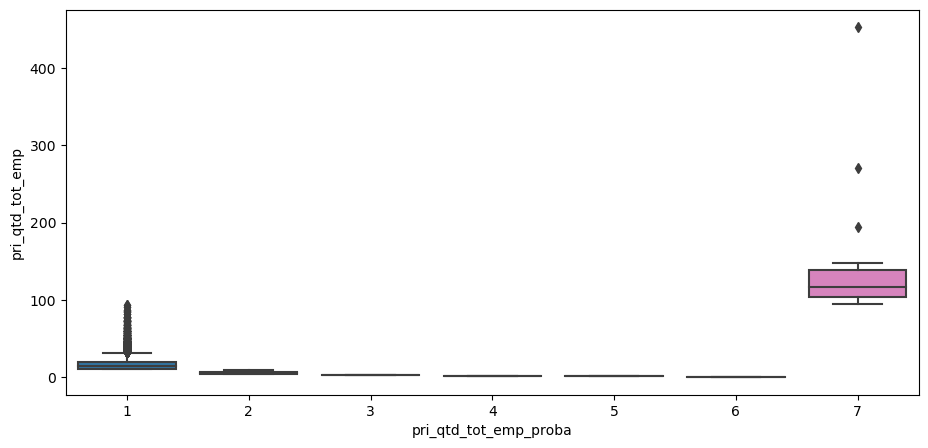

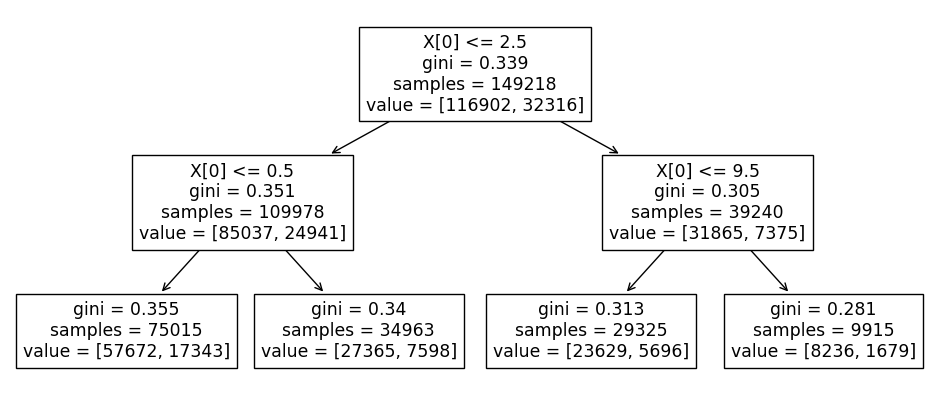

[0.16934, 0.19424, 0.21732, 0.23119]


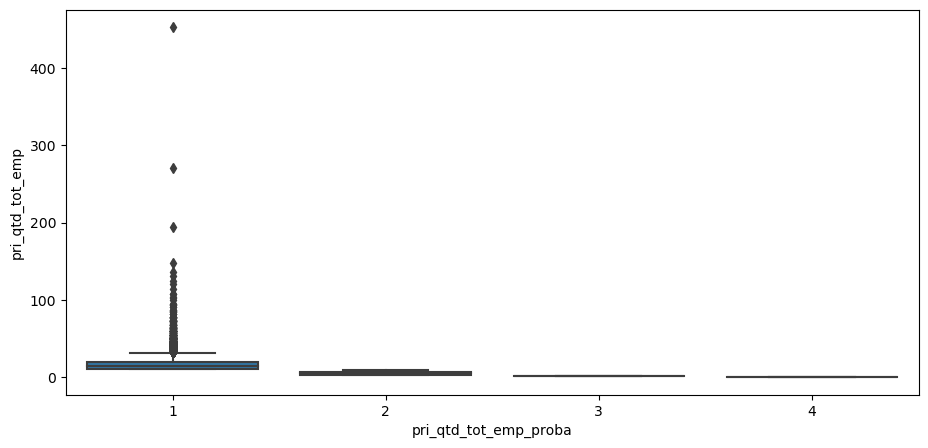

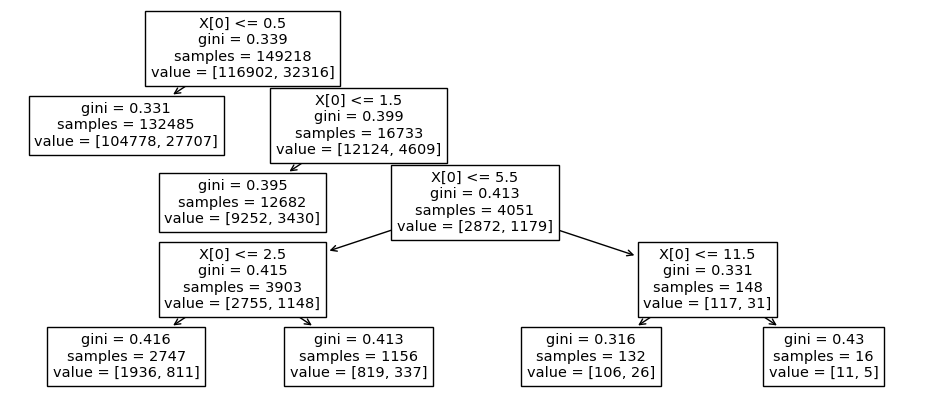

[0.19697, 0.20913, 0.27046, 0.29152, 0.29523, 0.3125]


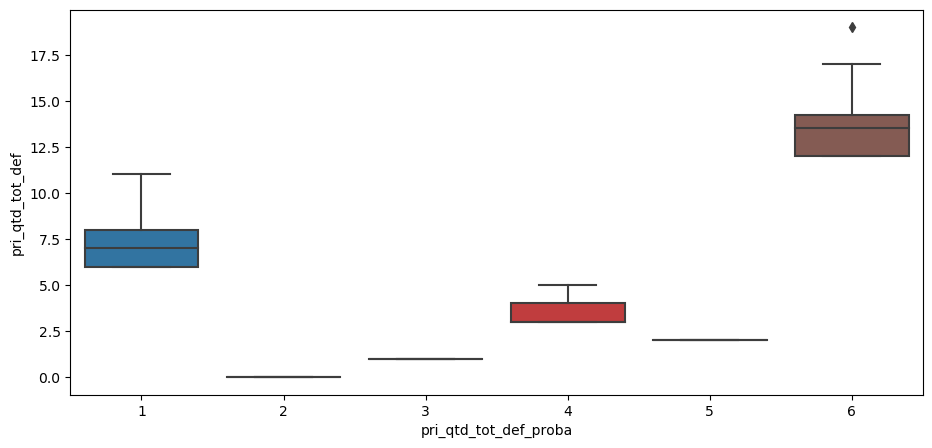

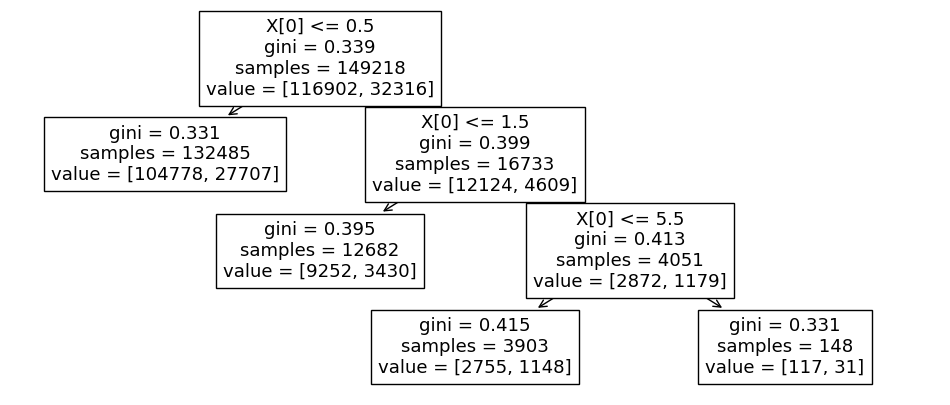

[0.20913, 0.20946, 0.27046, 0.29413]


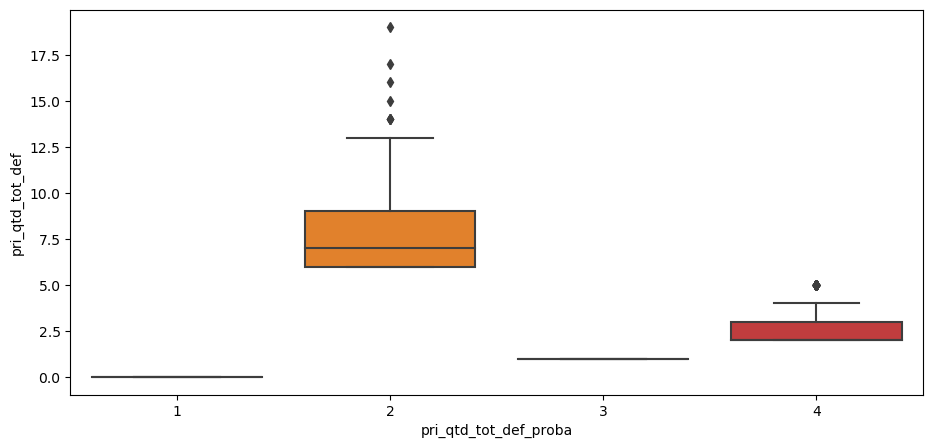

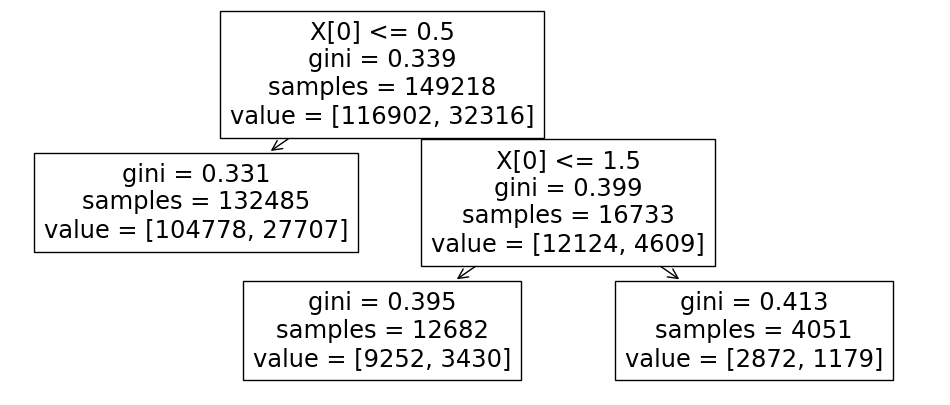

[0.20913, 0.27046, 0.29104]


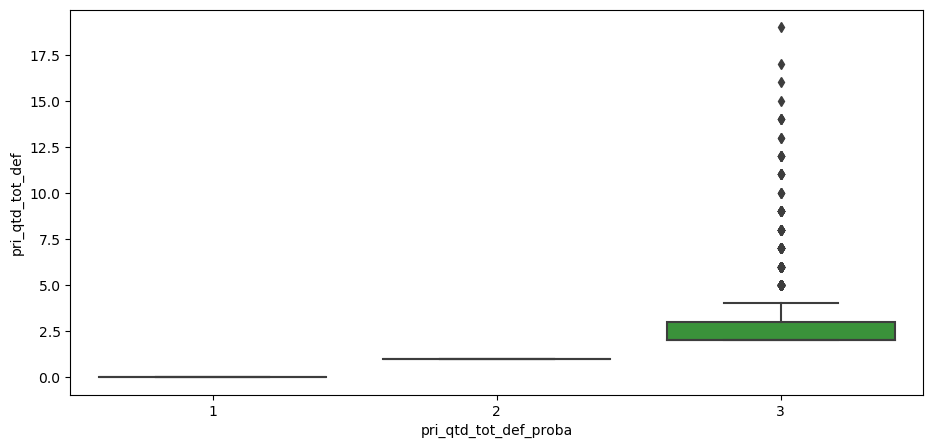

In [38]:
# após fazer o stepwise nas variáveis das contas, concluímos que estas seriam as variáveis que deveríamos manter
# aqui, discretizo-as
for var in ['pri_qtd_tot_emp', 'pri_qtd_tot_def']:
    tree_box_plot(df_x, var, 'default', [4, 3, 2], 42)

In [39]:
# aqui temos o dataframe de teste, cujas variáveis foram discretizadas e selecionadas

df_x.drop(columns = ['pri_qtd_tot_emp', 'pri_qtd_tot_def'], inplace = True)

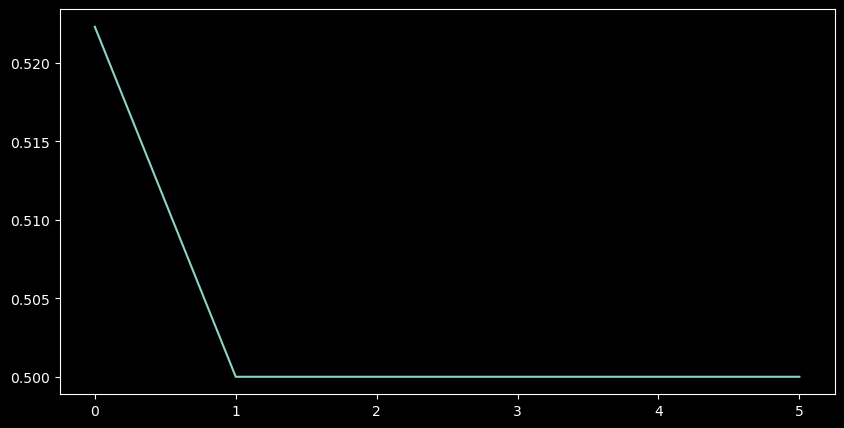

FEATURES INCLUÍDAS EM CADA STEP
0 : ['emprestimo_custo_proba', 'idade_proba', 'tem_pri_emp_proba', 'new_score', 'pri_qtd_tot_emp_proba', 'pri_qtd_tot_def_proba']
1 : ['emprestimo_custo_proba', 'idade_proba', 'tem_pri_emp_proba', 'pri_qtd_tot_emp_proba', 'pri_qtd_tot_def_proba']
2 : ['idade_proba', 'tem_pri_emp_proba', 'pri_qtd_tot_emp_proba', 'pri_qtd_tot_def_proba']
3 : ['tem_pri_emp_proba', 'pri_qtd_tot_emp_proba', 'pri_qtd_tot_def_proba']
4 : ['tem_pri_emp_proba', 'pri_qtd_tot_emp_proba']
5 : ['tem_pri_emp_proba']

SCORE DE CADA STEP
0 : 0.5223
1 : 0.5
2 : 0.5
3 : 0.5
4 : 0.5
5 : 0.5


In [40]:
# podemos fazer mais um stepwise, agora com todas as variáveis (pré-selecionadas)
plot_stepwise(df_x, 'default')

In [41]:
# não eliminamos nenhuma variável

# assim, concluímos a seleção de variáveis, trabalharemos com:

# ['emprestimo_custo_proba', 'idade_proba', 'tem_pri_emp_proba', 
#  'new_score', 'pri_qtd_tot_emp_proba', 'pri_qtd_tot_def_proba']

In [42]:
# AGORA PREPARAR DADOS DE TESTE

# a discretização foi feita com árovres de random_state = 123
# separar as series que serão inclusas no modelo, treinar árovres de random_state 123 nos dados de df_treino
# e transformar df_teste

In [43]:
df_teste = df_teste[['emprestimo_custo', 'nascimento', 'tem_pri_emp', 'pri_qtd_tot_emp', 'pri_qtd_tot_def', 
                     'score', 'default']]

df_teste['nascimento'] = df_teste['nascimento'].str[6:].apply(lambda x: year_to_age(x))
df_teste = df_teste.rename(columns = {'nascimento': 'idade'})

df_teste['tem_pri_emp'] = df_teste['tem_pri_emp'].apply(lambda x: time_unit_unification(x))

In [44]:
# discretização de dados de teste 
for var in ['emprestimo_custo', 'idade', 'tem_pri_emp', 'pri_qtd_tot_emp', 'pri_qtd_tot_def', 'score']:
    disc = DecisionTreeClassifier(max_depth = 2, random_state = 42)
    disc.fit(df_treino[[var]], df_treino['default'])
    df_teste[var + '_proba'] = disc.predict_proba(df_teste[[var]])[:, 1] 
    
for col in ['emprestimo_custo_proba', 'idade_proba', 'tem_pri_emp_proba','score_proba','pri_qtd_tot_emp_proba', 
                'pri_qtd_tot_def_proba']:
    probas = df_teste[col].unique().tolist()
    probas.sort()
    df_teste[col] = df_teste[col].apply(lambda x: discretize_proba(x, probas)) 

In [45]:
X_train = df_x[['emprestimo_custo_proba', 'idade_proba', 'tem_pri_emp_proba', 'new_score',
                'pri_qtd_tot_emp_proba', 'pri_qtd_tot_def_proba']]

y_train = df_x['default']

X_test = df_teste[['emprestimo_custo_proba', 'idade_proba', 'tem_pri_emp_proba', 'score_proba', 
           'pri_qtd_tot_emp_proba', 'pri_qtd_tot_def_proba']]

y_test = df_teste['default']

In [60]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

lista = [i[1] for i in lr.predict_proba(X_test)]

(2 * roc_auc_score(y_test, lista)) - 1

0.15638632326000468

In [47]:
lista = [i[1] for i in lr.predict_proba(X_train)]

(2 * roc_auc_score(y_train, lista)) - 1

# overfit

0.20213920134351704

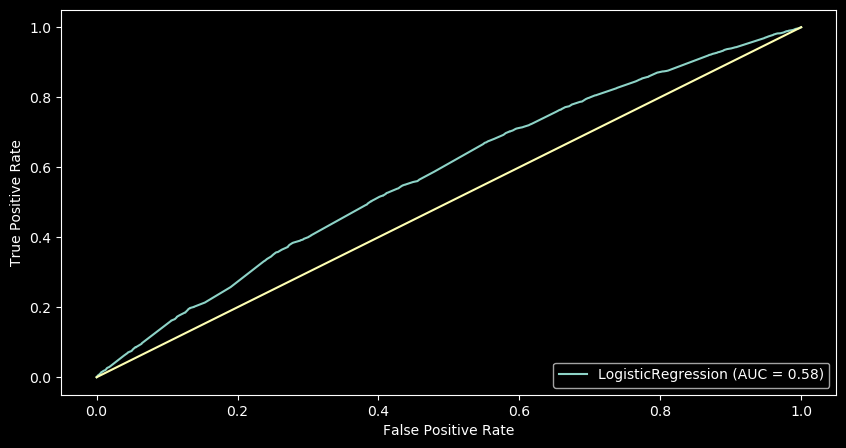

In [62]:
metrics.plot_roc_curve(lr, X_test, y_test)
plt.plot([0, 1], [0, 1])
plt.show()